**该jupyter用于绘制WaveNet网络涉及到的图片**

# 导入画图通用模块和参数

In [44]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import scipy as sp
import sys
import torch
import multiprocessing as mp
import tensorflow as tf

sys.path.insert(0, '../shared_modules/')
import plot_utils
import processing_utils

sys.path.insert(0, '../generate_data/raytracing/')
from model_gather import model_gather
sys.path.insert(0, '../WaveNet_train/')
from analysis import load_model, load_testdataset

In [51]:
# Global constants
DT = 0.002
T_GAIN = 2.5
DX,DZ = 5., 5.
NX,NZ = 128, 128
NSTEPS = 512
DELTARECi = 10
VLIM = 0.6
CLIM = (1500,3600)
gain = np.arange(NSTEPS)**T_GAIN
gain = gain / np.median(gain)
letters = ["a","b","c","d"]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

# 绘制数据

In [9]:
VEL_RUN = "layers_100"
SIM_RUN = "layers_100_gather"
isim=(0,0)
rootdir = '../generate_data/'
VEL_DIR =  rootdir + "velocity/" + VEL_RUN + "/"
OUT_SIM_DIR = rootdir + "gather/" + SIM_RUN + "/"
wavefields = np.load(OUT_SIM_DIR + "wavefields_%.8i_%.8i.npy"%(isim[0],isim[1]))
wavefields = wavefields[::4]
gather = np.load(OUT_SIM_DIR + "gather_%.8i_%.8i.npy"%(isim[0],isim[1]))
velocity = np.load(VEL_DIR + "velocity_%.8i.npy"%(isim[0]))
source_is = np.load(OUT_SIM_DIR + "source_is.npy")
receiver_is = np.load(OUT_SIM_DIR + "receiver_is.npy")
source_i = source_is[isim[0],isim[1]]
NREC = len(receiver_is)

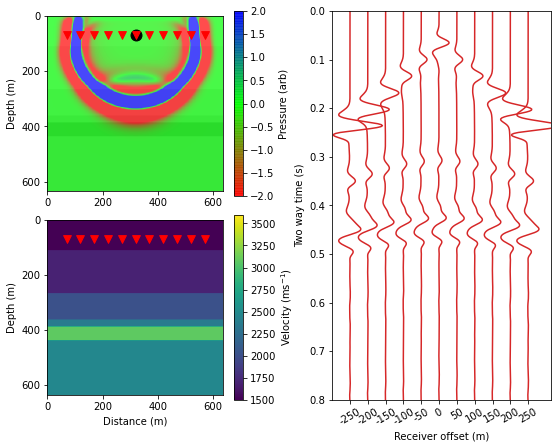

In [22]:
%matplotlib inline
plt.figure(figsize=(10,6))

# velocity & wavefield
plt.subplot2grid((2, 2), (0, 0), colspan=1)
plt.imshow(velocity.T, alpha=0.6, cmap="gray_r", vmin=CLIM[0], vmax=CLIM[1])
plt.imshow(wavefields[105].T, aspect=1, cmap=plot_utils.rgb, alpha=0.7, vmin = -2, vmax=2)
cb = plt.colorbar()
cb.ax.set_ylabel('Pressure (arb)')
plt.scatter(source_i[0], source_i[1], color='black', s=120)
plt.scatter(receiver_is[:,0], receiver_is[:,1], color='red', marker='v', s=60)
plt.gca().set_anchor('C')# centre plot
plt.yticks(np.arange(0,NZ,40)[::-1], (DZ*np.arange(0,NZ,40)[::-1]).astype(np.int))
plt.xticks(np.arange(0,NX,40), (DX*np.arange(0,NX,40)).astype(np.int))
plt.ylabel("Depth (m)")
plt.xlim(0, NX-1)
plt.ylim(NZ-1, 0)

# velocity
plt.subplot2grid((2, 2), (1, 0), colspan=1)
plt.imshow(velocity.T, vmin=CLIM[0], vmax=CLIM[1])
cb = plt.colorbar()
cb.ax.set_ylabel('Velocity ($\mathrm{ms}^{-1}$)')
plt.scatter(receiver_is[:,0], receiver_is[:,1], color='red', marker='v', s=60)
plt.gca().set_anchor('C')# centre plot
plt.yticks(np.arange(0,NZ,40)[::-1], (DZ*np.arange(0,NZ,40)[::-1]).astype(np.int))
plt.xticks(np.arange(0,NX,40), (DX*np.arange(0,NX,40)).astype(np.int))
plt.xlabel("Distance (m)")
plt.ylabel("Depth (m)")
plt.xlim(0, NX-1)
plt.ylim(NZ-1, 0)

# gather
lim = 1.
plt.subplot2grid((2, 2), (0, 1), rowspan=2)
for ir in range(NREC): plt.plot(lim*ir+gain*gather[ir,:], DT*np.arange(NSTEPS), color='tab:red')
plt.gca().invert_yaxis()
plt.xlabel("Receiver offset (m)")
plt.xticks(np.arange(0,NREC*lim,lim), [int(-(NREC-1)*DELTARECi*DX/2 + irec*DELTARECi*DX) for irec in range(NREC)])
plt.ylabel("Two way time (s)")
plt.ylim(DT*400,0)
plt.xlim(-lim, lim*(NREC-1)+lim+0.3)
plt.gca().set_anchor('C')# centre plot
plt.xticks(rotation=30)

plt.subplots_adjust(left=0.2, right=0.9, bottom=0.1, top=1., hspace=0.1, wspace=0.3)

figout_dir = './Fig/data_example/'
if not os.path.exists(figout_dir):
    os.makedirs(figout_dir)
plt.savefig(figout_dir+"WaveNet_data_example.png", bbox_inches='tight', pad_inches=0.01, dpi=300,facecolor='w')

# 绘制地震波传播动图

In [12]:
VEL_RUN = "layers_100"
SIM_RUN = "layers_100_gather"
DELTARECi = 10
isim=(0,0)
rootdir = '../generate_data/'
VEL_DIR =  rootdir + "velocity/" + VEL_RUN + "/"
OUT_SIM_DIR = rootdir + "gather/" + SIM_RUN + "/"
wavefields = np.load(OUT_SIM_DIR + "wavefields_%.8i_%.8i.npy"%(isim[0],isim[1]))
wavefields = wavefields[::4]
gather = np.load(OUT_SIM_DIR + "gather_%.8i_%.8i.npy"%(isim[0],isim[1]))
velocity = np.load(VEL_DIR + "velocity_%.8i.npy"%(isim[0]))
source_is = np.load(OUT_SIM_DIR + "source_is.npy")
receiver_is = np.load(OUT_SIM_DIR + "receiver_is.npy")

DELTAT = 0.002
source_i = source_is[isim[0],isim[1]]

print(velocity.shape, velocity[0,0])
print(wavefields.shape, np.max(wavefields))
print(gather.shape)
print(receiver_is.shape, source_is.shape)
#print(receiver_is)
#print(source_is)
print(source_i)

(128, 128) 1500.0
(512, 128, 128) 98.99535
(11, 512)
(11, 2) (100, 1, 2)
[64 14]


<IPython.core.display.Javascript object>


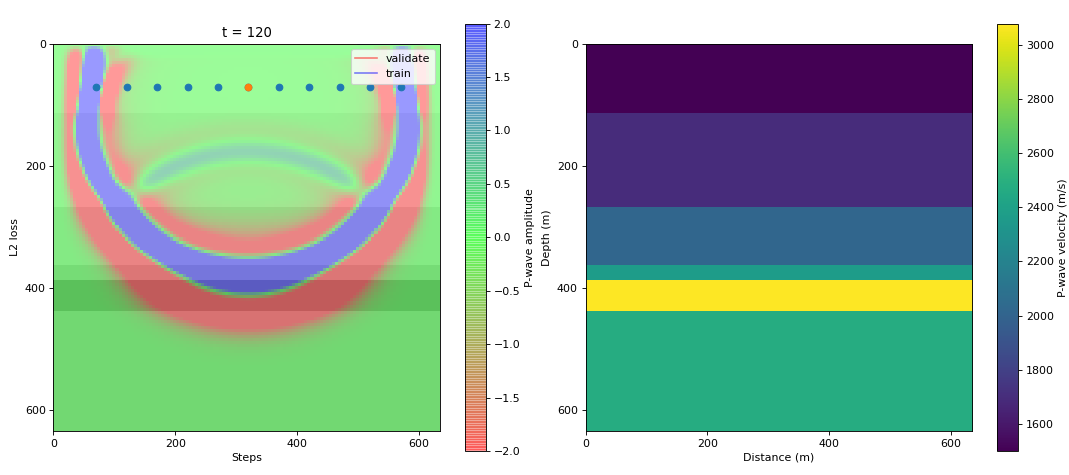

range(0, 512, 10)


In [30]:
# define initial plots
%matplotlib notebook
fig = plt.figure(figsize=(13.5,6))
plt.subplot(1,2,2)
plt.imshow(velocity.T, cmap="viridis")
plt.xticks(np.arange(0,NX,40), (DX*np.arange(0,NX,40)).astype(np.int))
plt.xlabel("Distance (m)")
plt.yticks(np.arange(0,NZ,40)[::-1], (DZ*np.arange(0,NZ,40)[::-1]).astype(np.int))
plt.xlim(0,NX-1)
plt.ylim(NZ-1,0)
plt.ylabel("Depth (m)")
cb = plt.colorbar()
cb.ax.set_ylabel('P-wave velocity (m/s)')
plt.subplot(1,2,1)
plt.imshow(velocity.T, alpha=0.4, cmap="gray_r")
plt.xticks(np.arange(0,NX,40), (DX*np.arange(0,NX,40)).astype(np.int))
plt.xlabel("Distance (m)")
plt.yticks(np.arange(0,NZ,40)[::-1], (DZ*np.arange(0,NZ,40)[::-1]).astype(np.int))
plt.xlim(0,NX-1)
plt.ylim(NZ-1,0)
plt.ylabel("Depth (m)")
im = plt.imshow(wavefields[0].T, aspect=1, cmap=plot_utils.rgb, alpha=0.4, vmin = -2, vmax=2)
cb = plt.colorbar()
cb.ax.set_ylabel('P-wave amplitude')
plt.scatter(receiver_is[:,0], receiver_is[:,1])
plt.scatter(source_i[0], source_i[1])

# define animation update function
def update(i):
    # set the data in the im object
    plt.title("t = %i"%(i))
    im.set_data(wavefields[i].T)
    return [im]# tells the animator which parts of the plot to update
# start animation
# important: keep the instance to maintain timer
ani = animation.FuncAnimation(fig, update, frames=range(0,wavefields.shape[0],10), interval=100, blit=False)

plt.subplots_adjust(left=0.05, right=1., bottom=0.05, top=0.95, hspace=0.0, wspace=0.1)
plt.show()
frames=range(0,wavefields.shape[0],10)
print(frames)
figout_dir = './Fig/data_example/'
if not os.path.exists(figout_dir):
    os.makedirs(figout_dir)
# ani.save(figout_dir+'wavefields.gif',writer='Pillow')

In [31]:
ani._stop()

# 地震正演

## loss曲线图

In [36]:
PATH= '../WaveNet_train/results/summaries/'
modle = 'layers_2000_forward/'
l1loss_test = 'run-.-tag-accuracy_loss_test_loss.csv'
l1loss_train = 'run-.-tag-accuracy_loss_train_loss.csv'
data = pd.read_csv(PATH + modle + l1loss_test)
test_Step = data['Step'].tolist()
l1loss_test = data['Value'].tolist()
data = pd.read_csv(PATH + modle + l1loss_train)
train_Step = data['Step'].tolist()
l1loss_train = data['Value'].tolist()

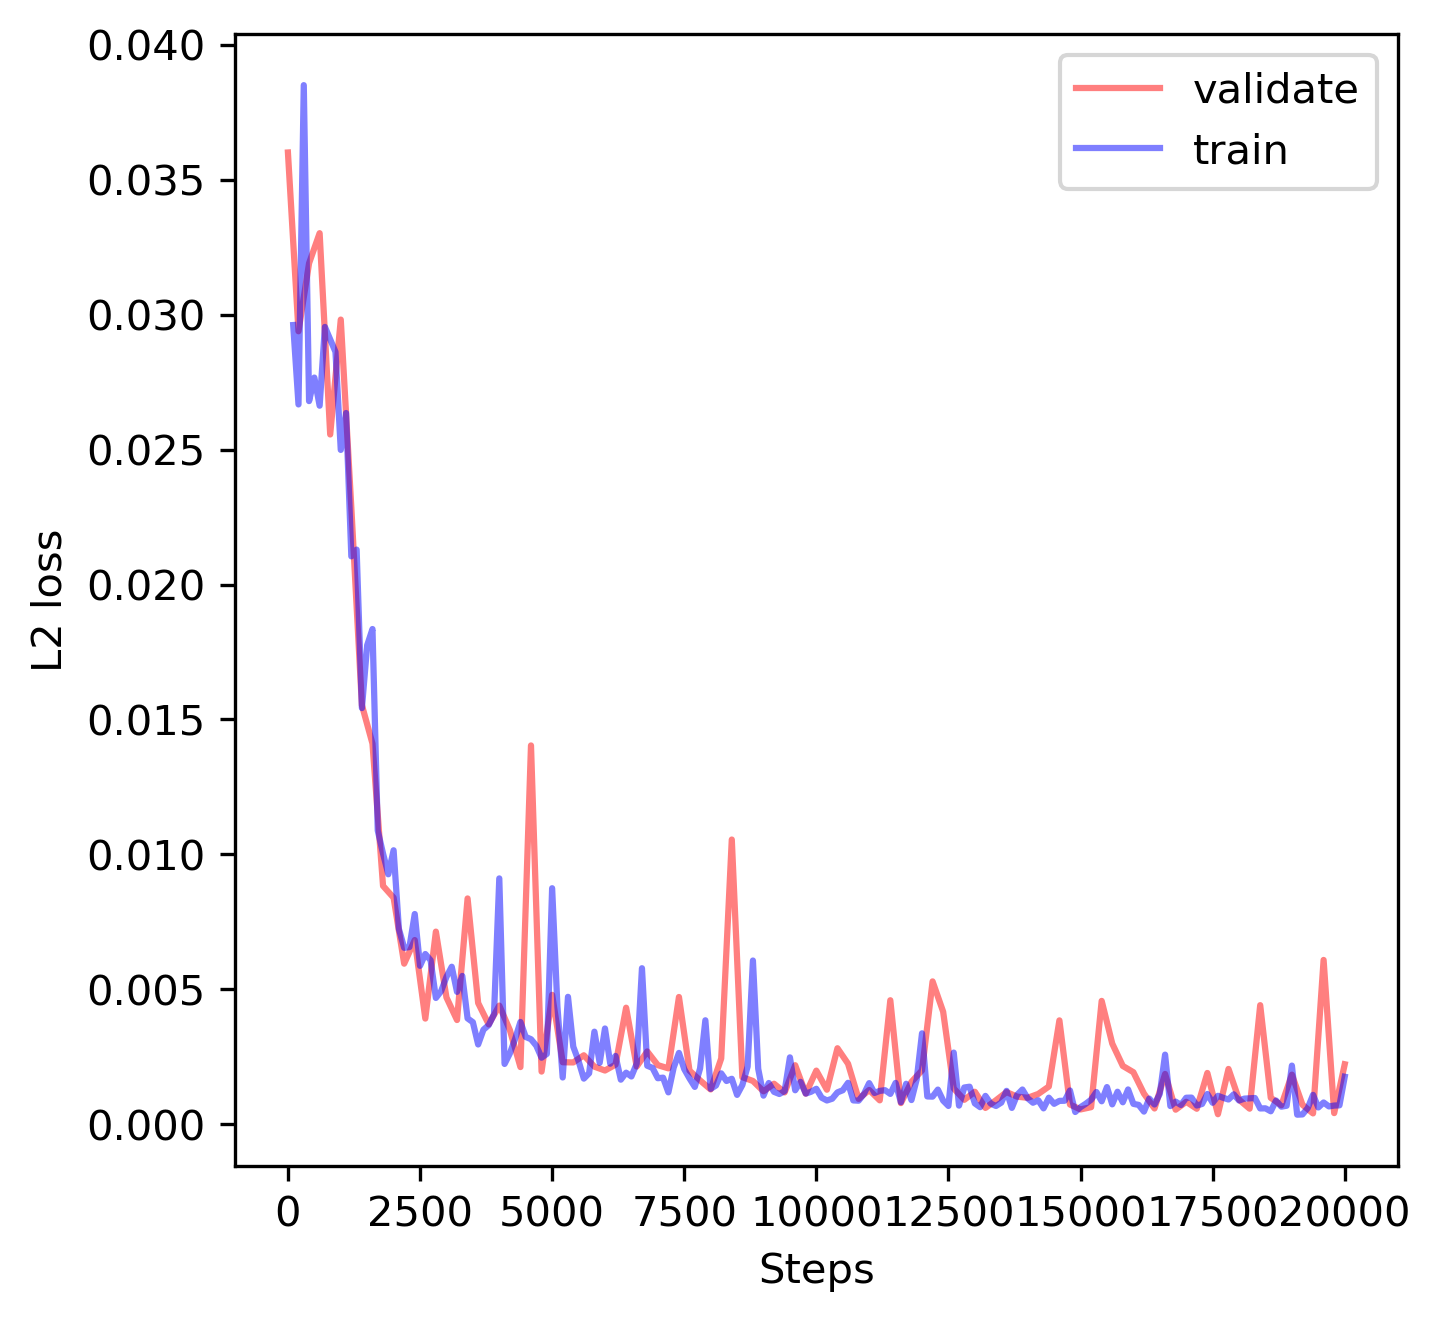

In [39]:
%matplotlib inline
fig = plt.figure(num=1, figsize=(5, 5),dpi=300)     #开启一个窗口，同时设置大小，分辨率

plt.plot(test_Step,l1loss_test,linestyle='-',alpha=0.5,color='r',label='validate')
plt.plot(train_Step,l1loss_train,linestyle='-',alpha=0.5,color='b',label='train')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('L2 loss')
# plt.ylim([0,0.005])
# plt.title('18000 examples')

figout_dir = './Fig/forward/'
if not os.path.exists(figout_dir):
    os.makedirs(figout_dir)
plt.savefig(figout_dir+'WaveNet_forward_L2_loss.png',bbox_inches = 'tight',dpi=300,facecolor='w')#保存图片

## 正演预测结果

In [52]:
DT = 0.002
T_GAIN = 2.5
DX = 5.
DZ = 5.
NSTEPS = 512
NZ = 128-14 # velocity traces have been pre-processed
NREC = 11
DELTARECi=10

In [53]:
# Load model and dataset
tf.reset_default_graph()
path = '../WaveNet_train/'
model, c_dict, input_features, sess = load_model("layers_2000_forward/model.ckpt-20000", rootdir=path+"results/",verbose=False)
rootdir = '../generate_data/data'
d = load_testdataset("layers_100_validate.bin", N_EXAMPLES=100, c_dict=c_dict, rootdir=rootdir,verbose=False)

# Get batches of test data
velocity_array, reflectivity_array, gather_array = d[1,2,3,9]
print(velocity_array.shape, reflectivity_array.shape, gather_array.shape)

# Inference
gather_prediction_array = sess.run(model.y, feed_dict={input_features["reflectivity"]: reflectivity_array})

Loading model from: ../WaveNet_train/results/models/layers_2000_forward/model.ckpt-20000
INFO:tensorflow:Restoring parameters from ../WaveNet_train/results/models/layers_2000_forward/model.ckpt-20000
(4, 114, 1) (4, 512, 1) (4, 512, 11)


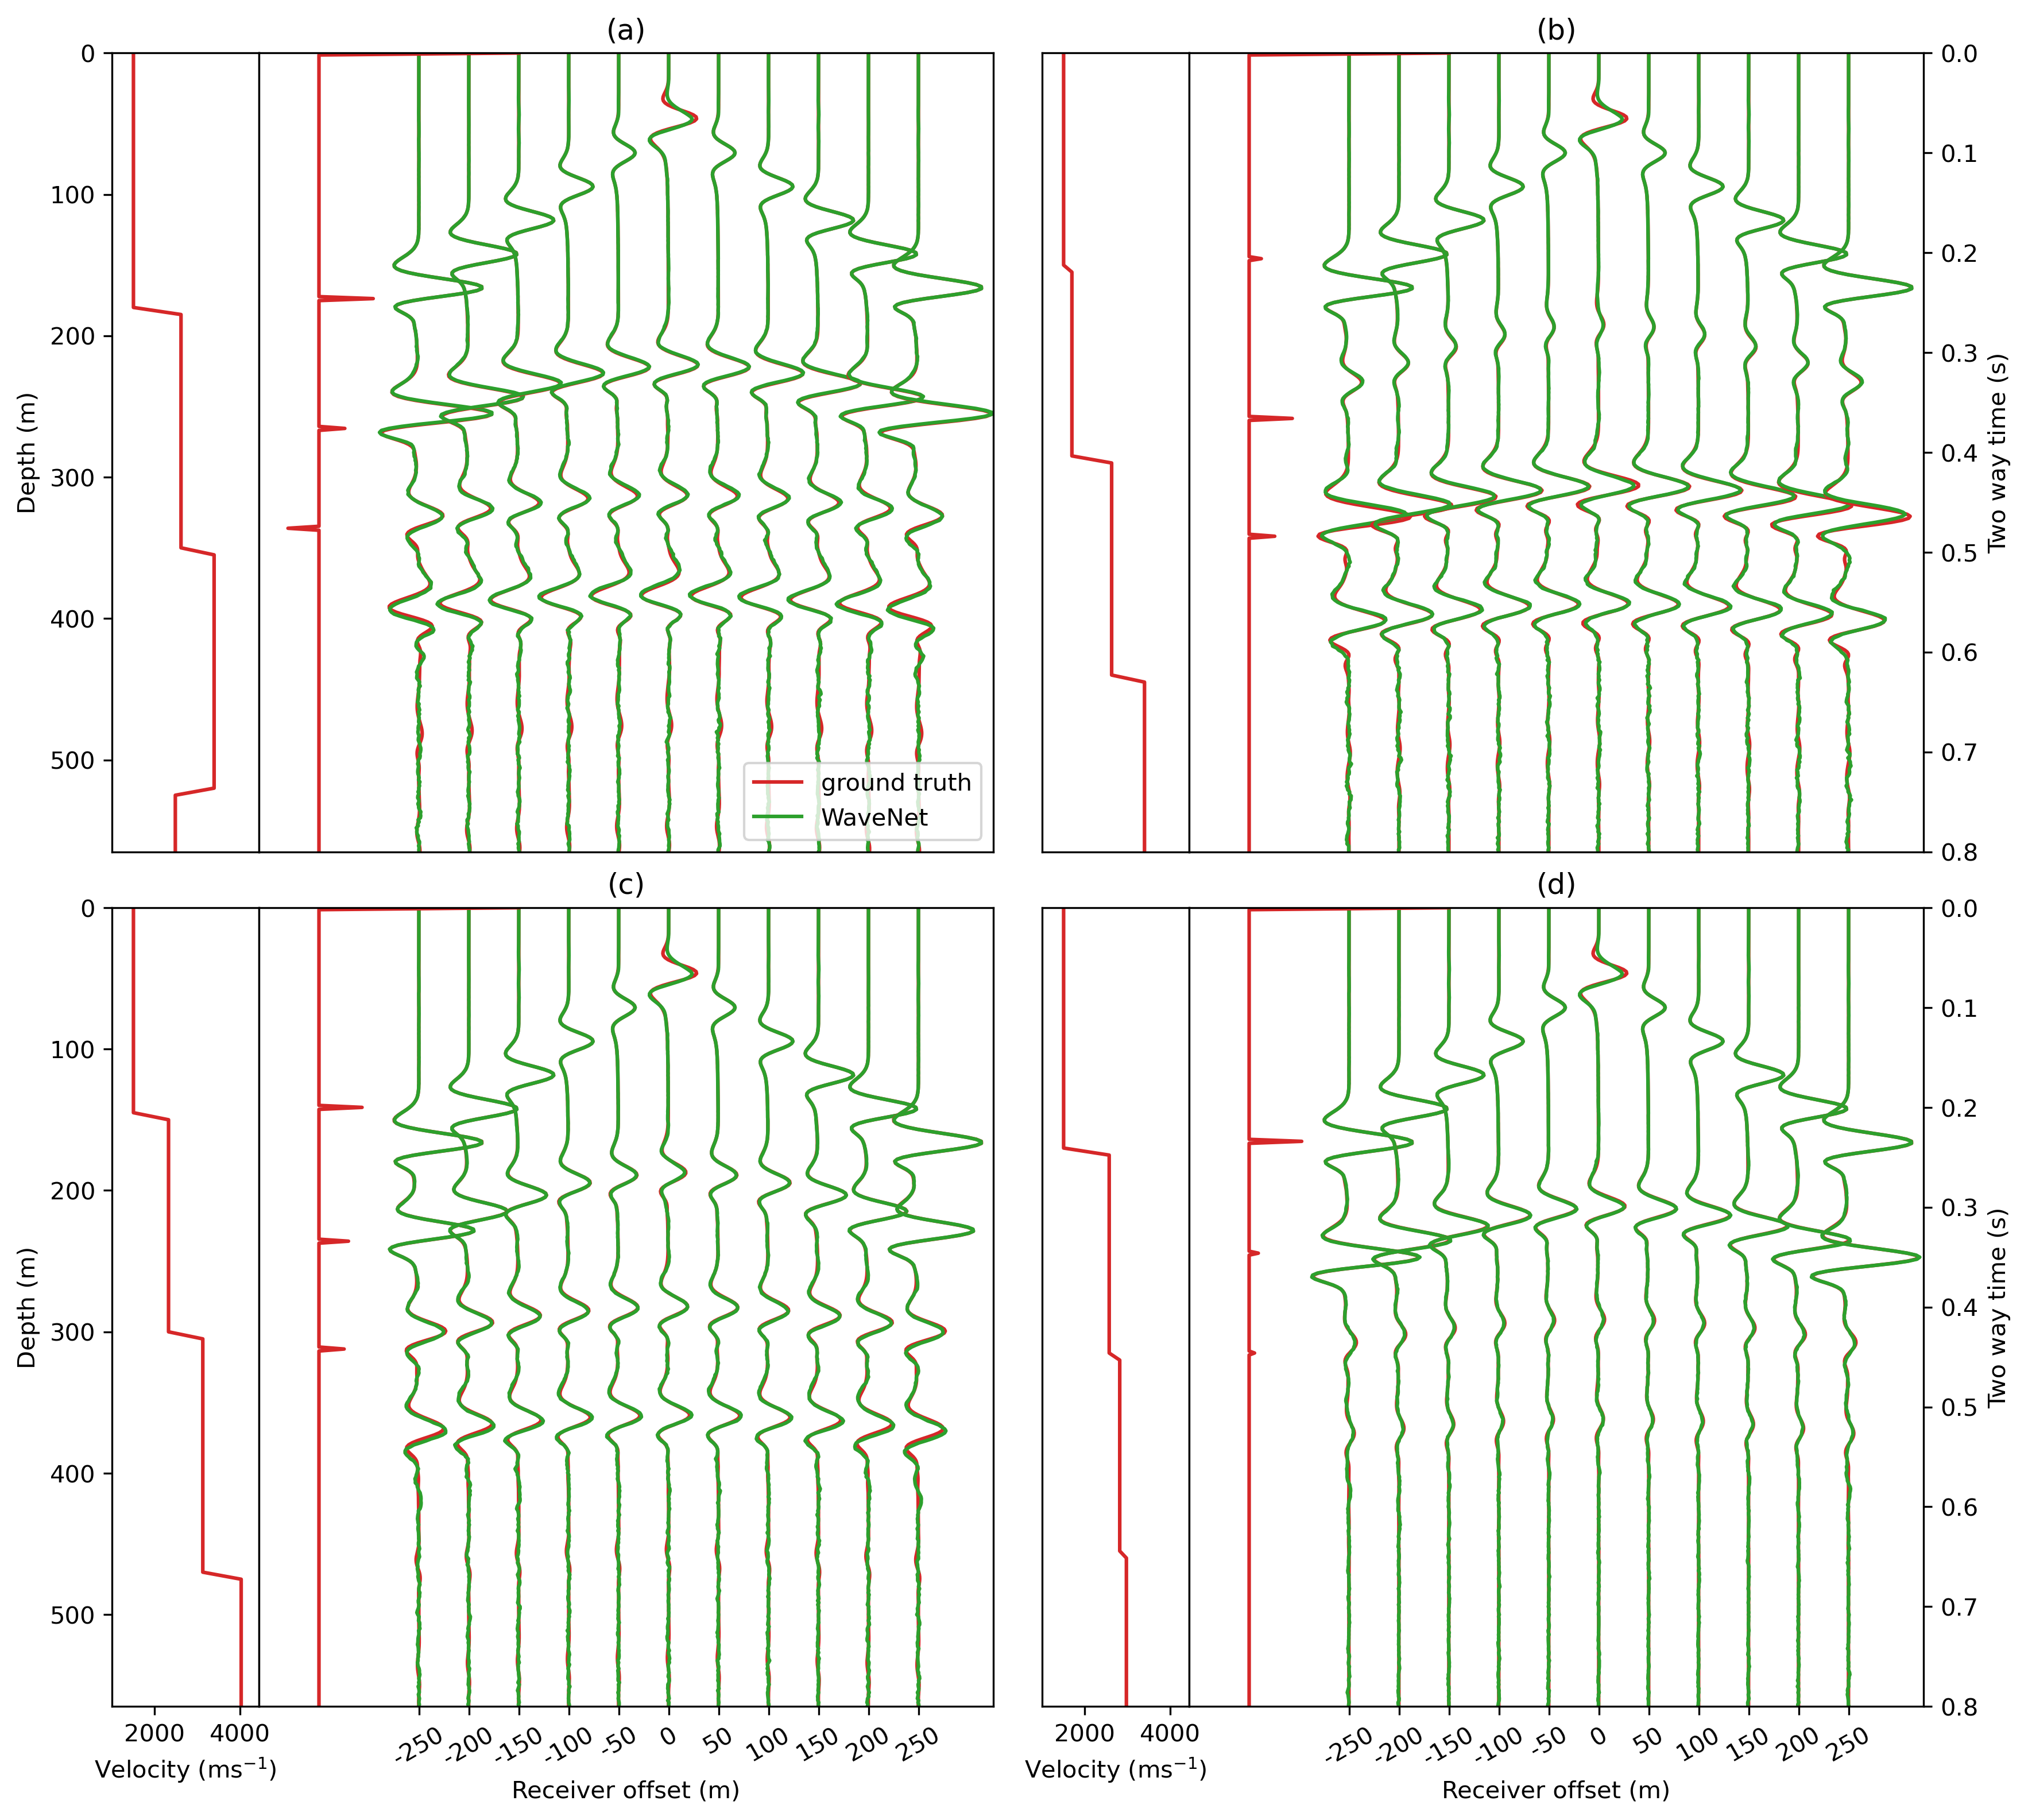

In [55]:
plt.figure(figsize=(12,12), dpi=300)

row_n = 0
for i,ib in enumerate([0,1,2,3]):
    if i == 2:
        row_n = 1
        i = 0
    if i == 3:
        i = 1
    
    # velocity
    plt.subplot2grid((2, 38), (row_n, 0+15*i+3*i+i), colspan=3)
    plt.plot(velocity_array[ib,:,0], DZ*np.arange(NZ), color='tab:red')
    
    plt.gca().invert_yaxis()
    if row_n == 1: plt.xlabel("Velocity ($\mathrm{ms}^{-1}$)")
    else: plt.xticks([])
    plt.xlim(1000,4450)
    plt.ylim(DZ*(NZ-1),0)
    if i==0: plt.ylabel("Depth (m)")
    else: plt.yticks([])
    
    
    # gather & reflectivity
    lim = 1.
    plt.subplot2grid((2, 38), (row_n, 3+15*i+3*i+i), colspan=15)
    for ir in range(NREC): 
        if ib == ir == 0:
            label1="ground truth"
            label2="WaveNet"
        else: label1 = label2 = None
                    
        plt.plot(lim*ir+gain*gather_array[ib,:,ir], DT*np.arange(NSTEPS), color='tab:red',label=label1)
        plt.plot(lim*ir+gain*gather_prediction_array[ib,:,ir], DT*np.arange(NSTEPS), color='tab:green',label=label2)
    
    plt.plot(-2*lim+4*reflectivity_array[ib,:,0], DT*np.arange(NSTEPS), color='tab:red')
    
    if ib == 0: plt.legend(loc=4)
    plt.title("(%s)"%(letters[ib]))
    plt.gca().invert_yaxis()
    if row_n == 1: 
        plt.xlabel("Receiver offset (m)")
        plt.xticks(np.arange(0, NREC*lim,lim), [int(-(NREC-1)*DELTARECi*DX/2 + irec*DELTARECi*DX) for irec in range(NREC)])
    else: plt.xticks([])
    if i==1: plt.ylabel("Two way time (s)")
    else: plt.yticks([])
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    plt.ylim(DT*400,0)
    plt.xlim(-3*lim-0.2, lim*(NREC-1)+lim+0.5)
    plt.xticks(rotation=30)

plt.subplots_adjust(left=0.1, right=1., bottom=0.1, top=.9, hspace=0.07, wspace=0.)

figout_dir = './Fig/forward/'
if not os.path.exists(figout_dir):
    os.makedirs(figout_dir)
plt.savefig(figout_dir+'WaveNet_forward_prediction.png',bbox_inches = 'tight',dpi=300,facecolor='w')#保存图片
# plt.savefig("../report_plots/fig04.pdf", bbox_inches='tight', pad_inches=0.01, dpi=300)

## 网络预测结果与传统褶积模型对比图

In [56]:
## RAY TRACING
velocity_array, reflectivity_array, gather_array = d[:]
print(velocity_array.shape, reflectivity_array.shape, gather_array.shape)

# Inference
gather_prediction_array = sess.run(model.y, feed_dict={input_features["reflectivity"]: reflectivity_array})


source = np.load("../generate_data/gather/source/gather_00000000_00000000.npy")[5]
print(source.shape)

x_receivers = DX*(DELTARECi*(np.arange(NREC)-NREC//2))
conv2d = np.zeros(gather_array.shape)
for ib in range(reflectivity_array.shape[0]):
    
    v0 = velocity_array[ib,:,0]
    ilayers = np.argwhere(np.diff(v0))[:,0]# ilayers stores left indices of interface (lower velocity value)
    v = np.concatenate([v0[ilayers],np.array([v0[-1]])],axis=0)
    z = np.concatenate([np.array([0]),DZ*(ilayers+1),np.array([DZ*NZ])], axis=0)# use right edges to define layer height
    rho = 2200*np.ones_like(v)
    dz = np.diff(z)
    assert len(dz) == len(v)
    
    if len(v): xs,dzs,vs,ps,rs = model_gather(dz,v,rho,0,0,x_receivers,DT,NSTEPS)
    else: rs = np.zeros((NREC,NSTEPS), dtype=float)

    conv2d[ib] = (rs.T).copy()

# SOURCE CONVOLUTION

for ib in range(velocity_array.shape[0]):
    for ir in range(NREC):
        conv2d[ib,:,ir] = 1.5*processing_utils.convolve_source(conv2d[ib,:,ir], source)
        
# LOSS (averaged over gather)

loss_conv2d = np.mean(np.abs(gain.reshape((1,NSTEPS,1))*(conv2d - gather_array)), axis=(1,2))# l1 loss  
print(loss_conv2d.shape)
loss = np.mean(np.abs(gain.reshape((1,NSTEPS,1))*(gather_prediction_array - gather_array)), axis=(1,2))# l1 loss 
print(loss.shape)

(100, 114, 1) (100, 512, 1) (100, 512, 11)
(512,)
(100,)
(100,)


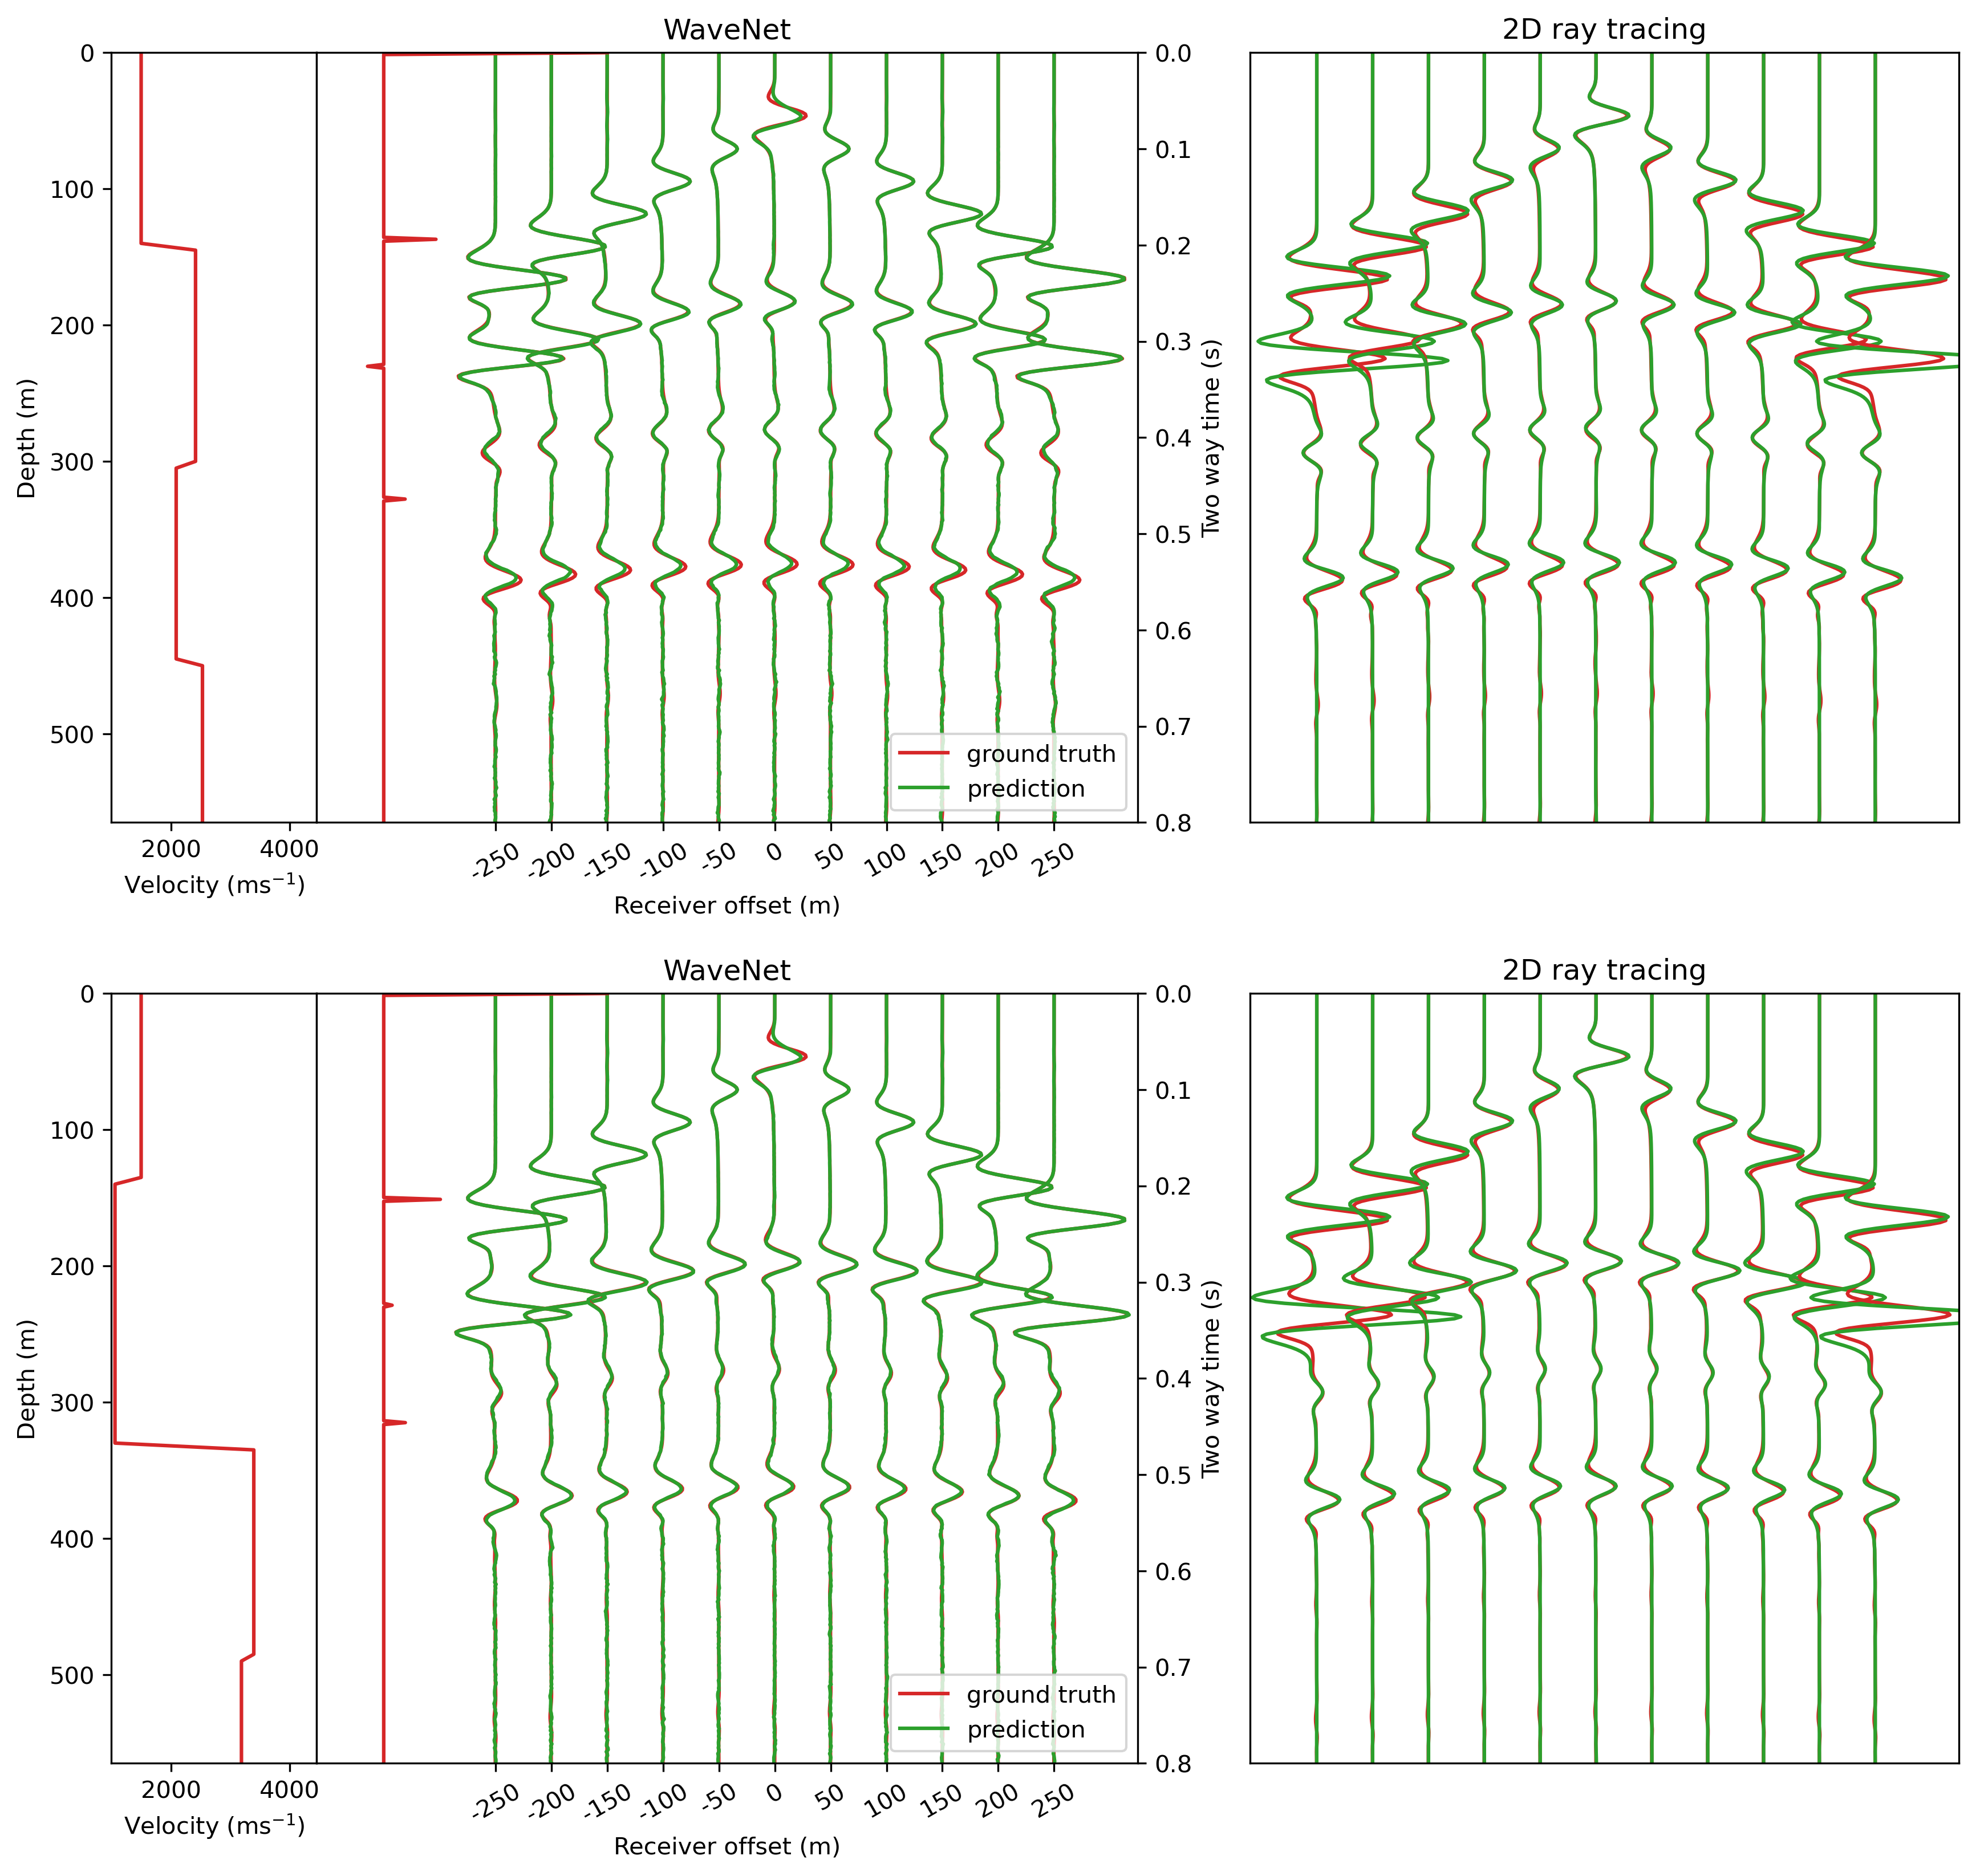

In [58]:
gather_prediction_arrays = [gather_prediction_array, conv2d]
names = ["WaveNet","2D ray tracing"]

def plot_gather(iname, ib, label=True, reflectivity=True, xlabel=True, ylabel=True):
    
    # gather & reflectivity
    lim = 1.
    for ir in range(NREC): 
        if label and ir==0:
            label1="ground truth"
            label2="prediction"
        else: label1 = label2 = None
        
        plt.plot(lim*ir+gain*gather_array[ib,:,ir], DT*np.arange(NSTEPS), color='tab:red',label=label1)
        plt.plot(lim*ir+gain*gather_prediction_arrays[iname][ib,:,ir], DT*np.arange(NSTEPS), color='tab:green',label=label2)
    
    if reflectivity:
        plt.plot(-2*lim+4*reflectivity_array[ib,:,0], DT*np.arange(NSTEPS), color='tab:red')
    
    if label:
        plt.legend(loc=4)
    plt.title(names[iname])
    
    plt.gca().invert_yaxis()
    if xlabel:
        plt.xlabel("Receiver offset (m)")
        plt.xticks(np.arange(0, NREC*lim,lim), [int(-(NREC-1)*DELTARECi*DX/2 + irec*DELTARECi*DX) for irec in range(NREC)])
    else: 
        plt.xticks([])
    if ylabel:
        plt.ylabel("Two way time (s)")
    else: 
        plt.yticks([])
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    plt.ylim(DT*400,0)
    if reflectivity:
        plt.xlim(-3*lim-0.2, lim*(NREC-1)+lim+0.5)
    else: 
        plt.xlim(-1*lim-0.2, lim*(NREC-1)+lim+0.5)
    plt.xticks(rotation=30)
    
    
f = plt.figure(figsize=(12,10), dpi=300)

# velocity axis
ax = f.add_axes([0,0.55,
                 0.1,0.45])# xmin, ymin, dx, and dy
plt.plot(velocity_array[42,:,0], DZ*np.arange(NZ), color='tab:red')
plt.gca().invert_yaxis()
plt.xlabel("Velocity ($\mathrm{ms}^{-1}$)")
plt.xlim(1000,4450)
plt.ylim(DZ*(NZ-1),0)
plt.ylabel("Depth (m)")

# gathers

ax = f.add_axes([0.1, 0.55,
                 0.4,0.45])# xmin, ymin, dx, and dy
plot_gather(0, 42)
    
ax = f.add_axes([0.5+0.0545,0.55,
                 0.4-0.0545,0.45])# xmin, ymin, dx, and dy
plot_gather(1, 42, reflectivity=False, xlabel=False, ylabel=False, label=False)


# velocity axis
ax = f.add_axes([0,0.,
                 0.1,0.45])# xmin, ymin, dx, and dy
plt.plot(velocity_array[7,:,0], DZ*np.arange(NZ), color='tab:red')
plt.gca().invert_yaxis()
plt.xlabel("Velocity ($\mathrm{ms}^{-1}$)")
plt.xlim(1000,4450)
plt.ylim(DZ*(NZ-1),0)
plt.ylabel("Depth (m)")


ax = f.add_axes([0.1, 0.,
                 0.4,0.45])# xmin, ymin, dx, and dy
plot_gather(0, 8)
    
ax = f.add_axes([0.5+0.0545,0.,
                 0.4-0.0545,0.45])# xmin, ymin, dx, and dy
plot_gather(1, 8, reflectivity=False, xlabel=False, ylabel=False, label=False)


figout_dir = './Fig/forward/'
if not os.path.exists(figout_dir):
    os.makedirs(figout_dir)
plt.savefig(figout_dir+'WaveNet_forward_prediction_comparison.png',bbox_inches = 'tight',dpi=300,facecolor='w')#保存图片


## 测试数据误差直方统计图

(100,)
(100,)


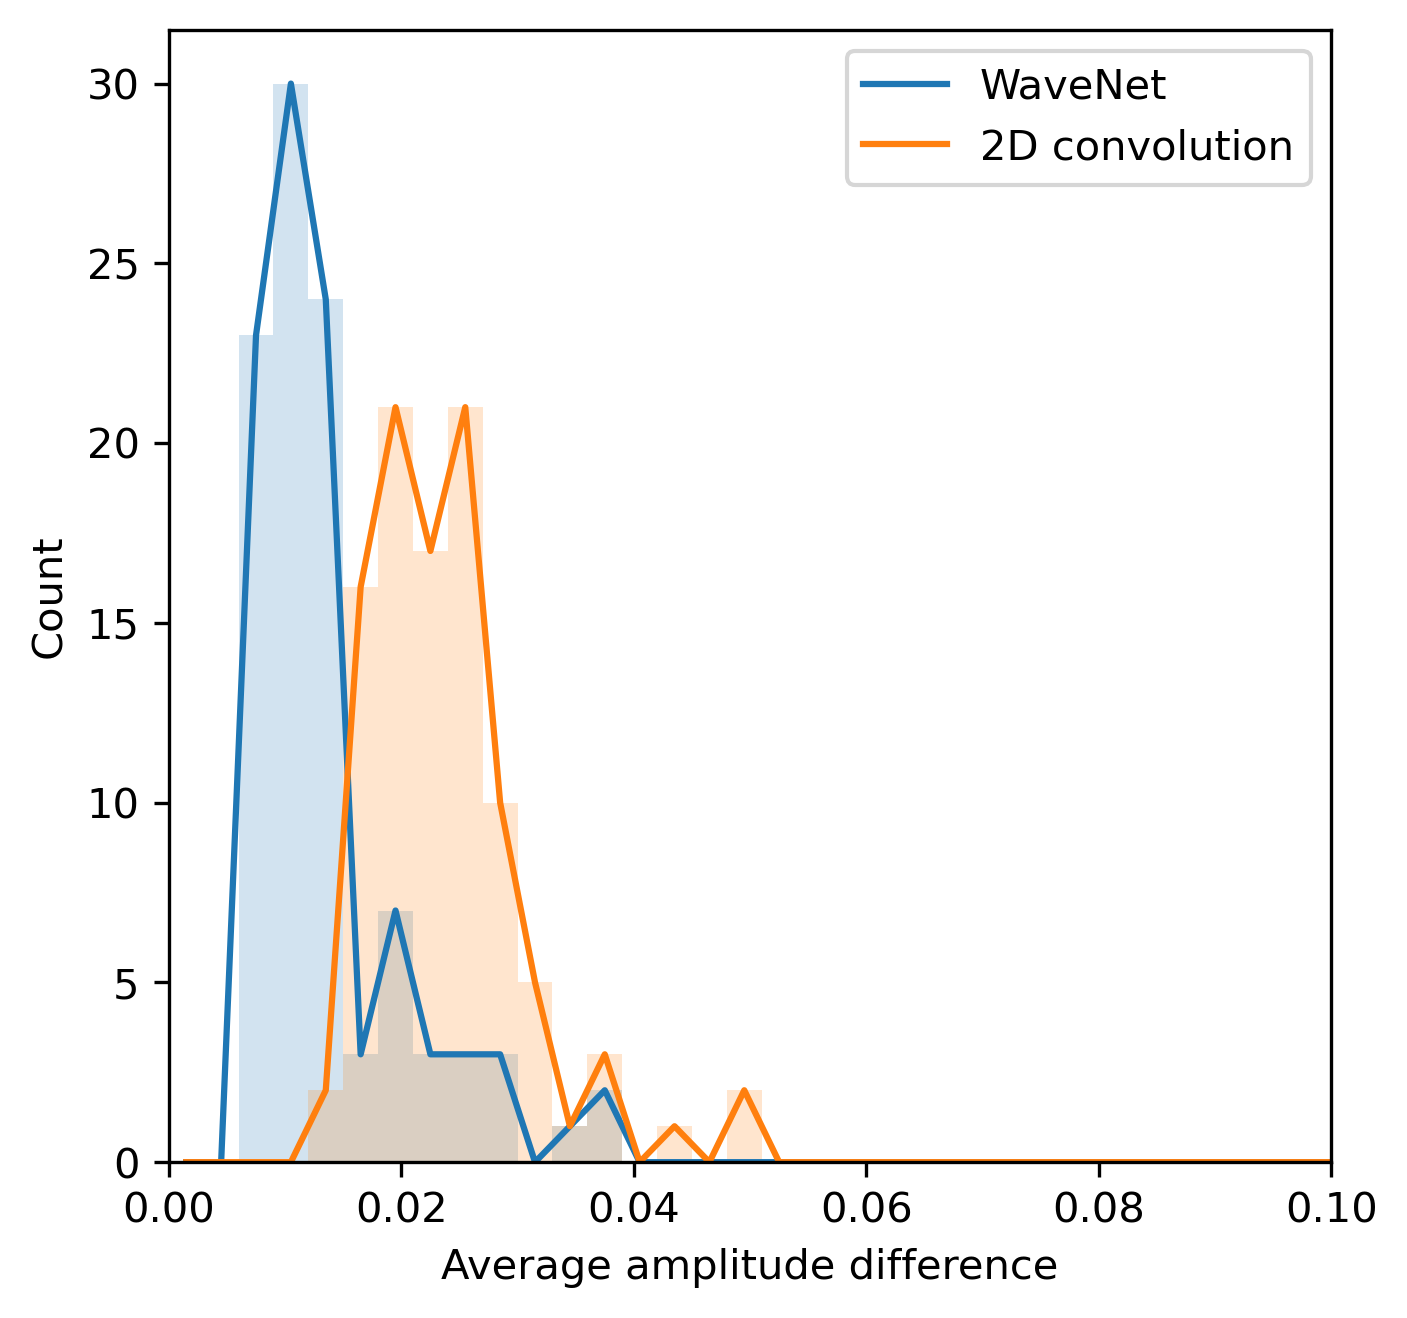

In [60]:
loss_conv2d = np.mean(np.abs(gain.reshape((1,NSTEPS,1))*(conv2d - gather_array)), axis=(1,2))# l1 loss  
print(loss_conv2d.shape)
loss = np.mean(np.abs(gain.reshape((1,NSTEPS,1))*(gather_prediction_array - gather_array)), axis=(1,2))# l1 loss 
print(loss.shape)


f = plt.figure(figsize=(5,5), dpi=300)
x = np.arange(0,0.2,0.003)
plt.plot(x[:-1]+(x[1]-x[0])/2.,np.histogram(loss, bins=x)[0], label="WaveNet", color=colors[0])
plt.hist(loss, bins=x, histtype='stepfilled', alpha=0.2, color=colors[0])
plt.plot(x[:-1]+(x[1]-x[0])/2.,np.histogram(loss_conv2d, bins=x)[0], label="2D convolution", color=colors[1])
plt.hist(loss_conv2d, bins=x, histtype='stepfilled', alpha=0.2, color=colors[1])
plt.xlim(0,0.1)
plt.ylabel("Count")
plt.xlabel("Average amplitude difference")
plt.legend(loc=1)


# plt.savefig("../report_plots/wavenet_histogram.png", bbox_inches='tight', pad_inches=0.01, dpi=300,facecolor='w')
figout_dir = './Fig/forward/'
if not os.path.exists(figout_dir):
    os.makedirs(figout_dir)
plt.savefig(figout_dir+'WaveNet_histogram.png',bbox_inches = 'tight',dpi=300,facecolor='w')#保存图片

# 地震反演

## 使用L1训练

### loss曲线图

In [65]:
PATH= '../WaveNet_train/results/summaries/'
modle = 'layers_2000_inverse_l1/'
l1loss_test = 'run-.-tag-accuracy_loss_test_loss.csv'
l1loss_train = 'run-.-tag-accuracy_loss_train_loss.csv'
data = pd.read_csv(PATH + modle + l1loss_test)
test_Step = data['Step'].tolist()
l1loss_test = data['Value'].tolist()
data = pd.read_csv(PATH + modle + l1loss_train)
train_Step = data['Step'].tolist()
l1loss_train = data['Value'].tolist()

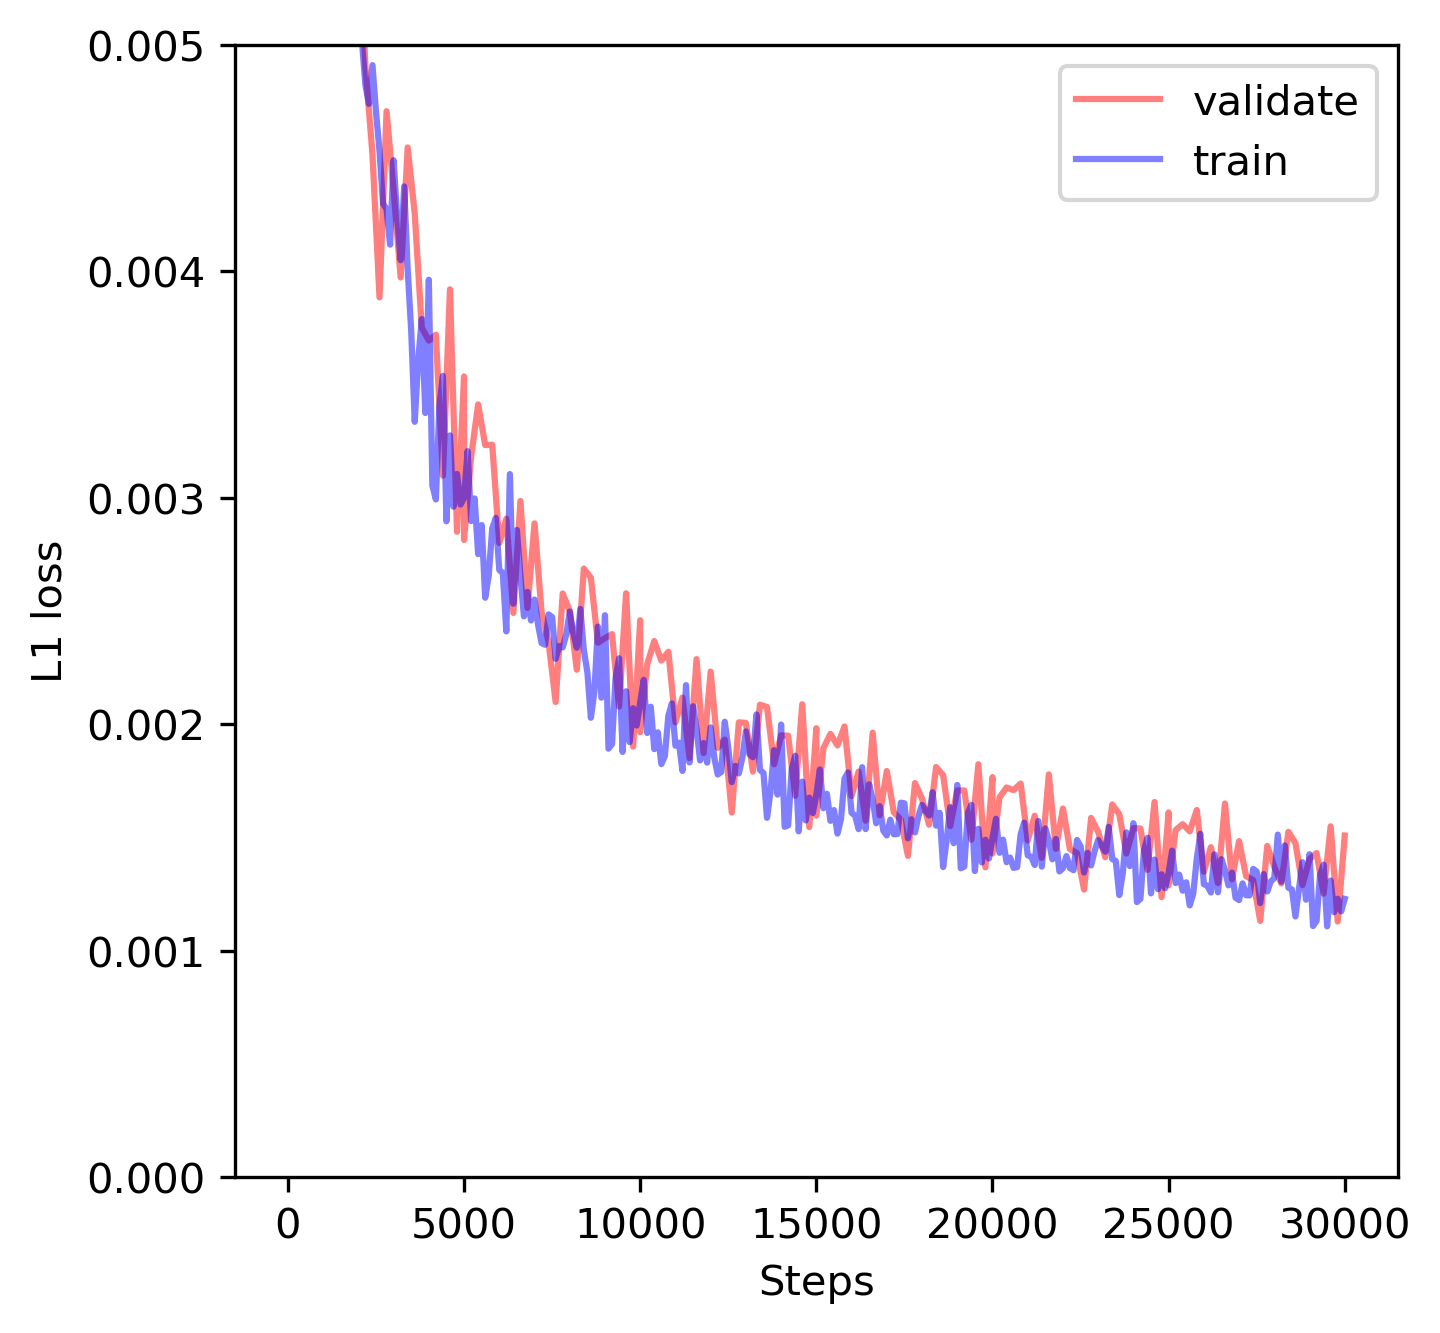

In [67]:
%matplotlib inline
fig = plt.figure(num=1, figsize=(5, 5),dpi=300)     #开启一个窗口，同时设置大小，分辨率

plt.plot(test_Step,l1loss_test,linestyle='-',alpha=0.5,color='r',label='validate')
plt.plot(train_Step,l1loss_train,linestyle='-',alpha=0.5,color='b',label='train')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('L1 loss')
plt.ylim([0,0.005])
# plt.title('18000 examples')

figout_dir = './Fig/inverse/'
if not os.path.exists(figout_dir):
    os.makedirs(figout_dir)
plt.savefig(figout_dir+'WaveNet_inverse_L1_loss.png',bbox_inches = 'tight',dpi=300,facecolor='w')#保存图片

### 预测结果图

In [68]:
# Load model and dataset
tf.reset_default_graph()
path = '../WaveNet_train/'
model, c_dict, input_features, sess = load_model("layers_2000_inverse_l1/model.ckpt-30000", rootdir=path+"results/",verbose=False)
rootdir = '../generate_data/data'
d = load_testdataset("layers_100_validate.bin", N_EXAMPLES=100, c_dict=c_dict, rootdir=rootdir,verbose=False)
# Get batches of test data
index=12
# velocity_array, reflectivity_array, gather_array = d[42,17,24,31]
velocity_array, reflectivity_array, gather_array = d[42,17,24,31]
print(velocity_array.shape, reflectivity_array.shape, gather_array.shape)

# Inference
reflectivity_prediction_array = sess.run(model.y, feed_dict={input_features["gather"]: gather_array})

Loading model from: ../WaveNet_train/results/models/layers_2000_inverse_l1/model.ckpt-30000
INFO:tensorflow:Restoring parameters from ../WaveNet_train/results/models/layers_2000_inverse_l1/model.ckpt-30000
(4, 114, 1) (4, 512, 1) (4, 512, 11)


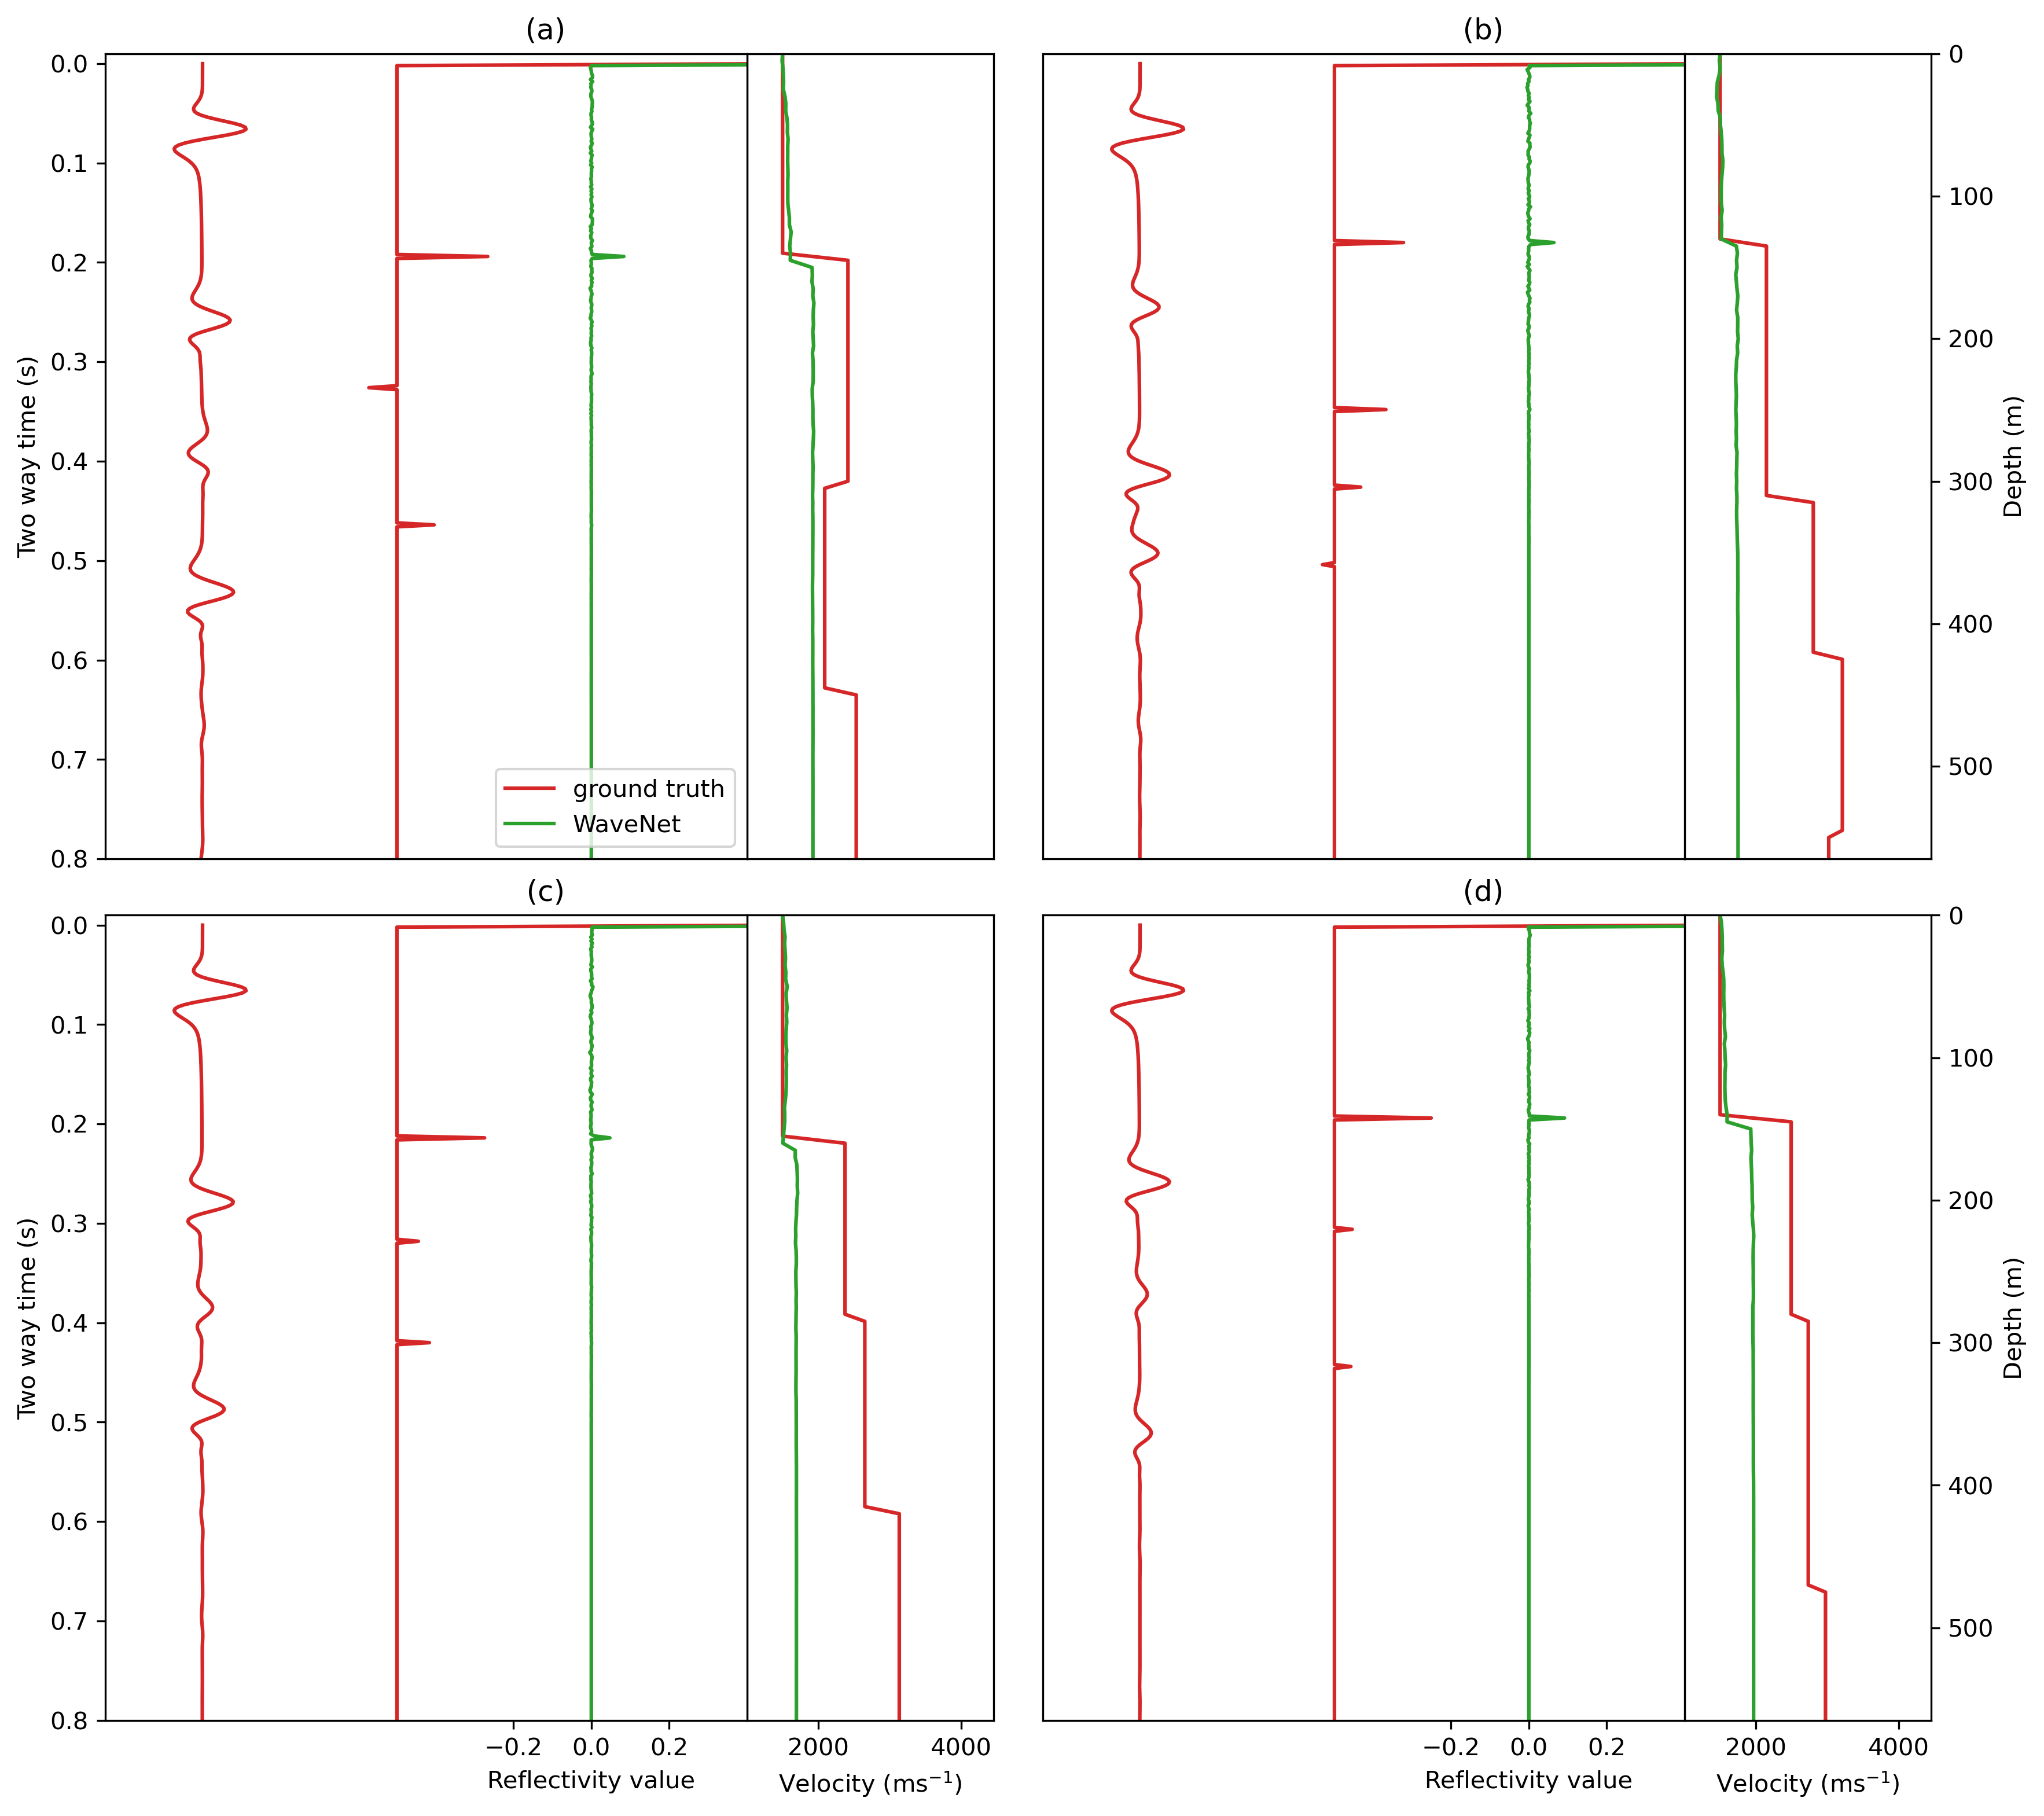

In [70]:
plt.figure(figsize=(12,12), dpi=300)

row_n = 0
for i,ib in enumerate([0,1,2,3]):
    if i == 2:
        row_n = 1
        i = 0
    if i == 3:
        i = 1
    
    v_d = processing_utils.get_velocity_trace(reflectivity_prediction_array[ib,:,0], 
                                              qc=False, srate=DT, DZ=DZ, NZ=NZ, v0=1500.)
    
    # velocity
    plt.subplot2grid((2, 38), (row_n, 13+13*i+5*i+i), colspan=5)
    
    plt.plot(velocity_array[ib,:,0], DZ*np.arange(NZ), color='tab:red',label="ground truth")
    plt.plot(v_d, DZ*np.arange(NZ), color='tab:green',label="WaveNet")
    
    plt.gca().invert_yaxis()
    if row_n == 1: plt.xlabel("Velocity ($\mathrm{ms}^{-1}$)")
    else: plt.xticks([])
    plt.xlim(1000,4450)
    plt.ylim(DZ*(NZ-1),0)
    if i==1: 
        plt.ylabel("Depth (m)")
        plt.gca().yaxis.tick_right()
        plt.gca().yaxis.set_label_position("right")
    else: plt.yticks([])
    
    # gather & reflectivity
    plt.subplot2grid((2, 38), (row_n, 0+13*i+5*i+i), colspan=13)
    if ib == 0:
        label1="ground truth"
        label2="WaveNet"
    else: label1 = label2 = None
    
    lim = 0.2
    plt.plot(-1+lim*gain*gather_array[ib,:,5], DT*np.arange(NSTEPS), color='tab:red',label=label1)
    plt.plot(-0.5+reflectivity_array[ib,:,0], DT*np.arange(NSTEPS), color='tab:red')
    plt.plot(0+reflectivity_prediction_array[ib,:,0], DT*np.arange(NSTEPS), color='tab:green',label=label2)
    if ib == 0: plt.legend(loc=4)
    
    plt.title("                          (%s)"%(letters[ib]))
    
    plt.gca().invert_yaxis()
    if row_n == 1: 
        plt.xlabel("                                           Reflectivity value")
        plt.xticks([-0.2, 0, 0.2])
    else: plt.xticks([])
    if i==0: plt.ylabel("Two way time (s)")
    else: plt.yticks([])
    plt.ylim(DT*400,-0.01)
    plt.xlim(-1-0.25, 0.4)

plt.subplots_adjust(left=0.1, right=1., bottom=0.1, top=.9, hspace=0.07, wspace=0.00)
figout_dir = './Fig/inverse/'
if not os.path.exists(figout_dir):
    os.makedirs(figout_dir)
plt.savefig(figout_dir+'WaveNet_inverse_L1_prediction.png',bbox_inches = 'tight',dpi=300,facecolor='w')#保存图片


## 使用L2训练

### loss曲线图

In [71]:
PATH= '../WaveNet_train/results/summaries/'
modle = 'layers_2000_inverse_l2/'
l1loss_test = 'run-.-tag-accuracy_loss_test_loss.csv'
l1loss_train = 'run-.-tag-accuracy_loss_train_loss.csv'
data = pd.read_csv(PATH + modle + l1loss_test)
test_Step = data['Step'].tolist()
l1loss_test = data['Value'].tolist()
data = pd.read_csv(PATH + modle + l1loss_train)
train_Step = data['Step'].tolist()
l1loss_train = data['Value'].tolist()

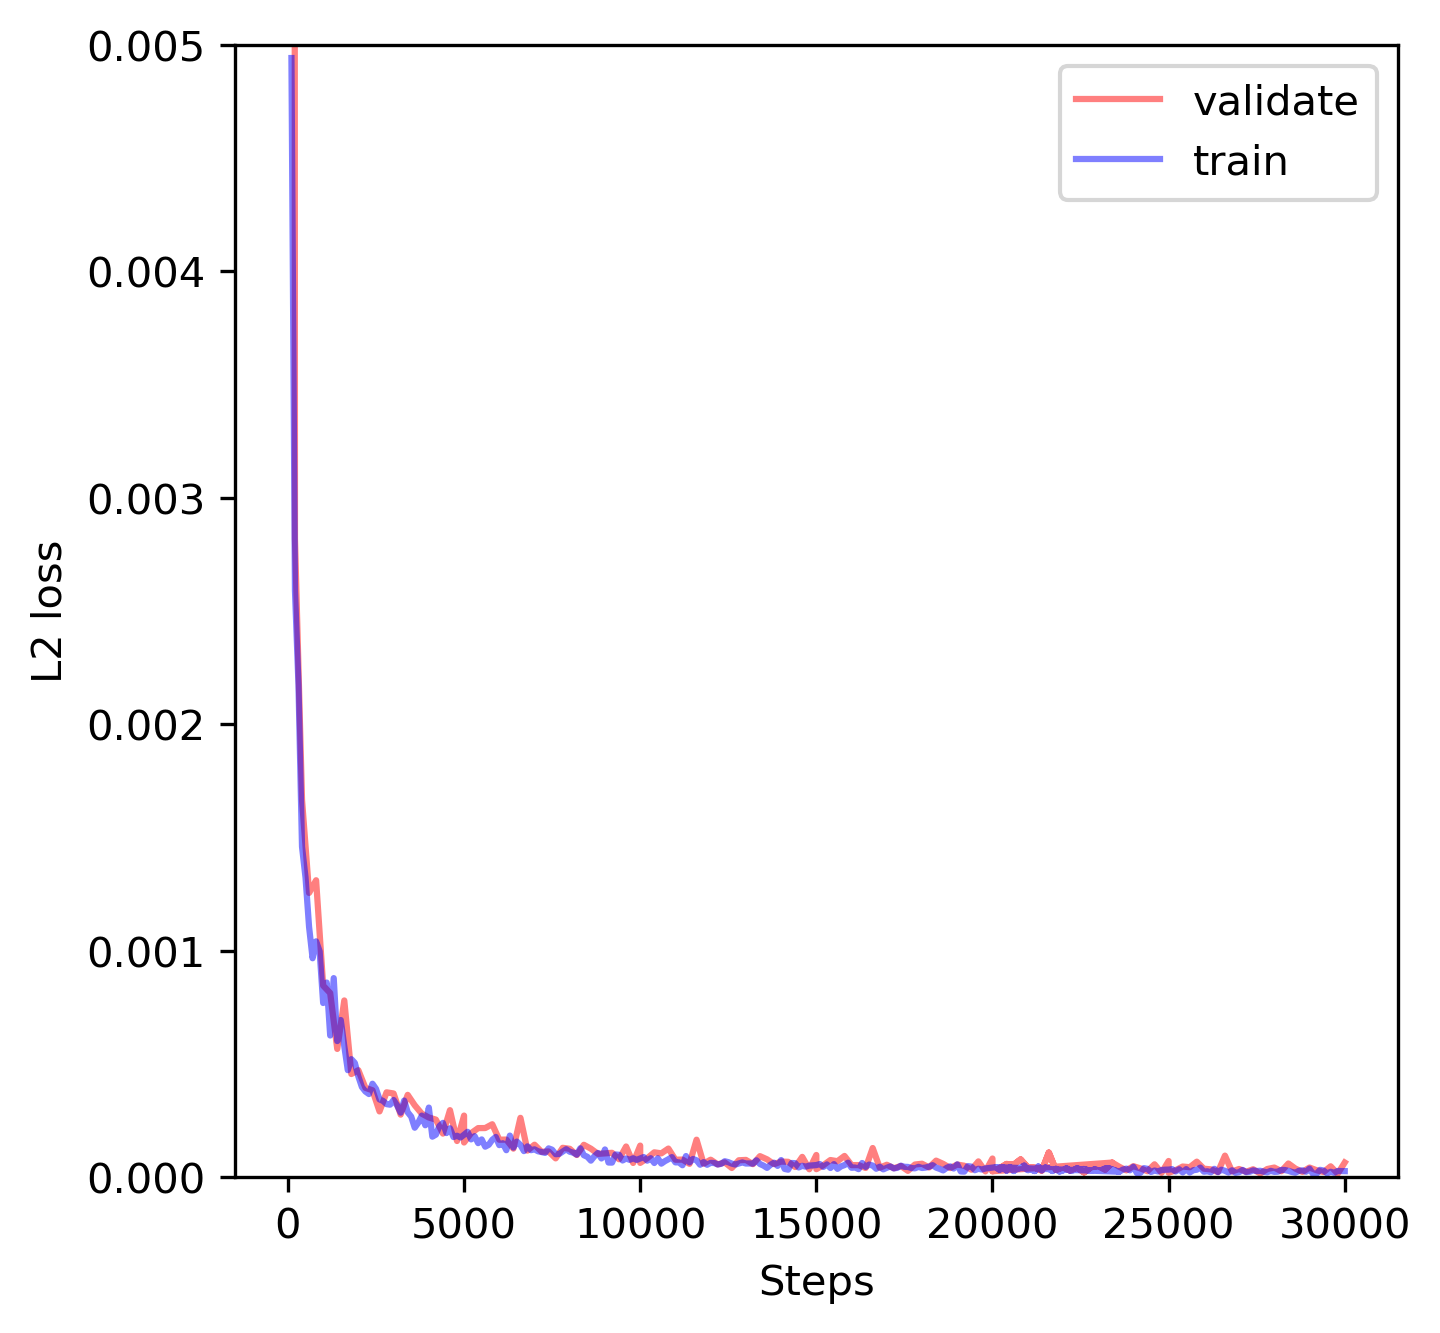

In [72]:
%matplotlib inline
fig = plt.figure(num=1, figsize=(5, 5),dpi=300)     #开启一个窗口，同时设置大小，分辨率

plt.plot(test_Step,l1loss_test,linestyle='-',alpha=0.5,color='r',label='validate')
plt.plot(train_Step,l1loss_train,linestyle='-',alpha=0.5,color='b',label='train')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('L2 loss')
plt.ylim([0,0.005])
# plt.title('18000 examples')

figout_dir = './Fig/inverse/'
if not os.path.exists(figout_dir):
    os.makedirs(figout_dir)
plt.savefig(figout_dir+'WaveNet_inverse_L2_loss.png',bbox_inches = 'tight',dpi=300,facecolor='w')#保存图片

### 预测结果图

In [73]:
# Load model and dataset
tf.reset_default_graph()
path = '../WaveNet_train/'
model, c_dict, input_features, sess = load_model("layers_2000_inverse_l2/model.ckpt-30000", rootdir=path+"results/",verbose=False)
rootdir = '../generate_data/data'
d = load_testdataset("layers_100_validate.bin", N_EXAMPLES=100, c_dict=c_dict, rootdir=rootdir,verbose=False)
# Get batches of test data
index=12
# velocity_array, reflectivity_array, gather_array = d[42,17,24,31]
velocity_array, reflectivity_array, gather_array = d[42,17,24,31]
print(velocity_array.shape, reflectivity_array.shape, gather_array.shape)

# Inference
reflectivity_prediction_array = sess.run(model.y, feed_dict={input_features["gather"]: gather_array})

Loading model from: ../WaveNet_train/results/models/layers_2000_inverse_l2/model.ckpt-30000
INFO:tensorflow:Restoring parameters from ../WaveNet_train/results/models/layers_2000_inverse_l2/model.ckpt-30000
(4, 114, 1) (4, 512, 1) (4, 512, 11)


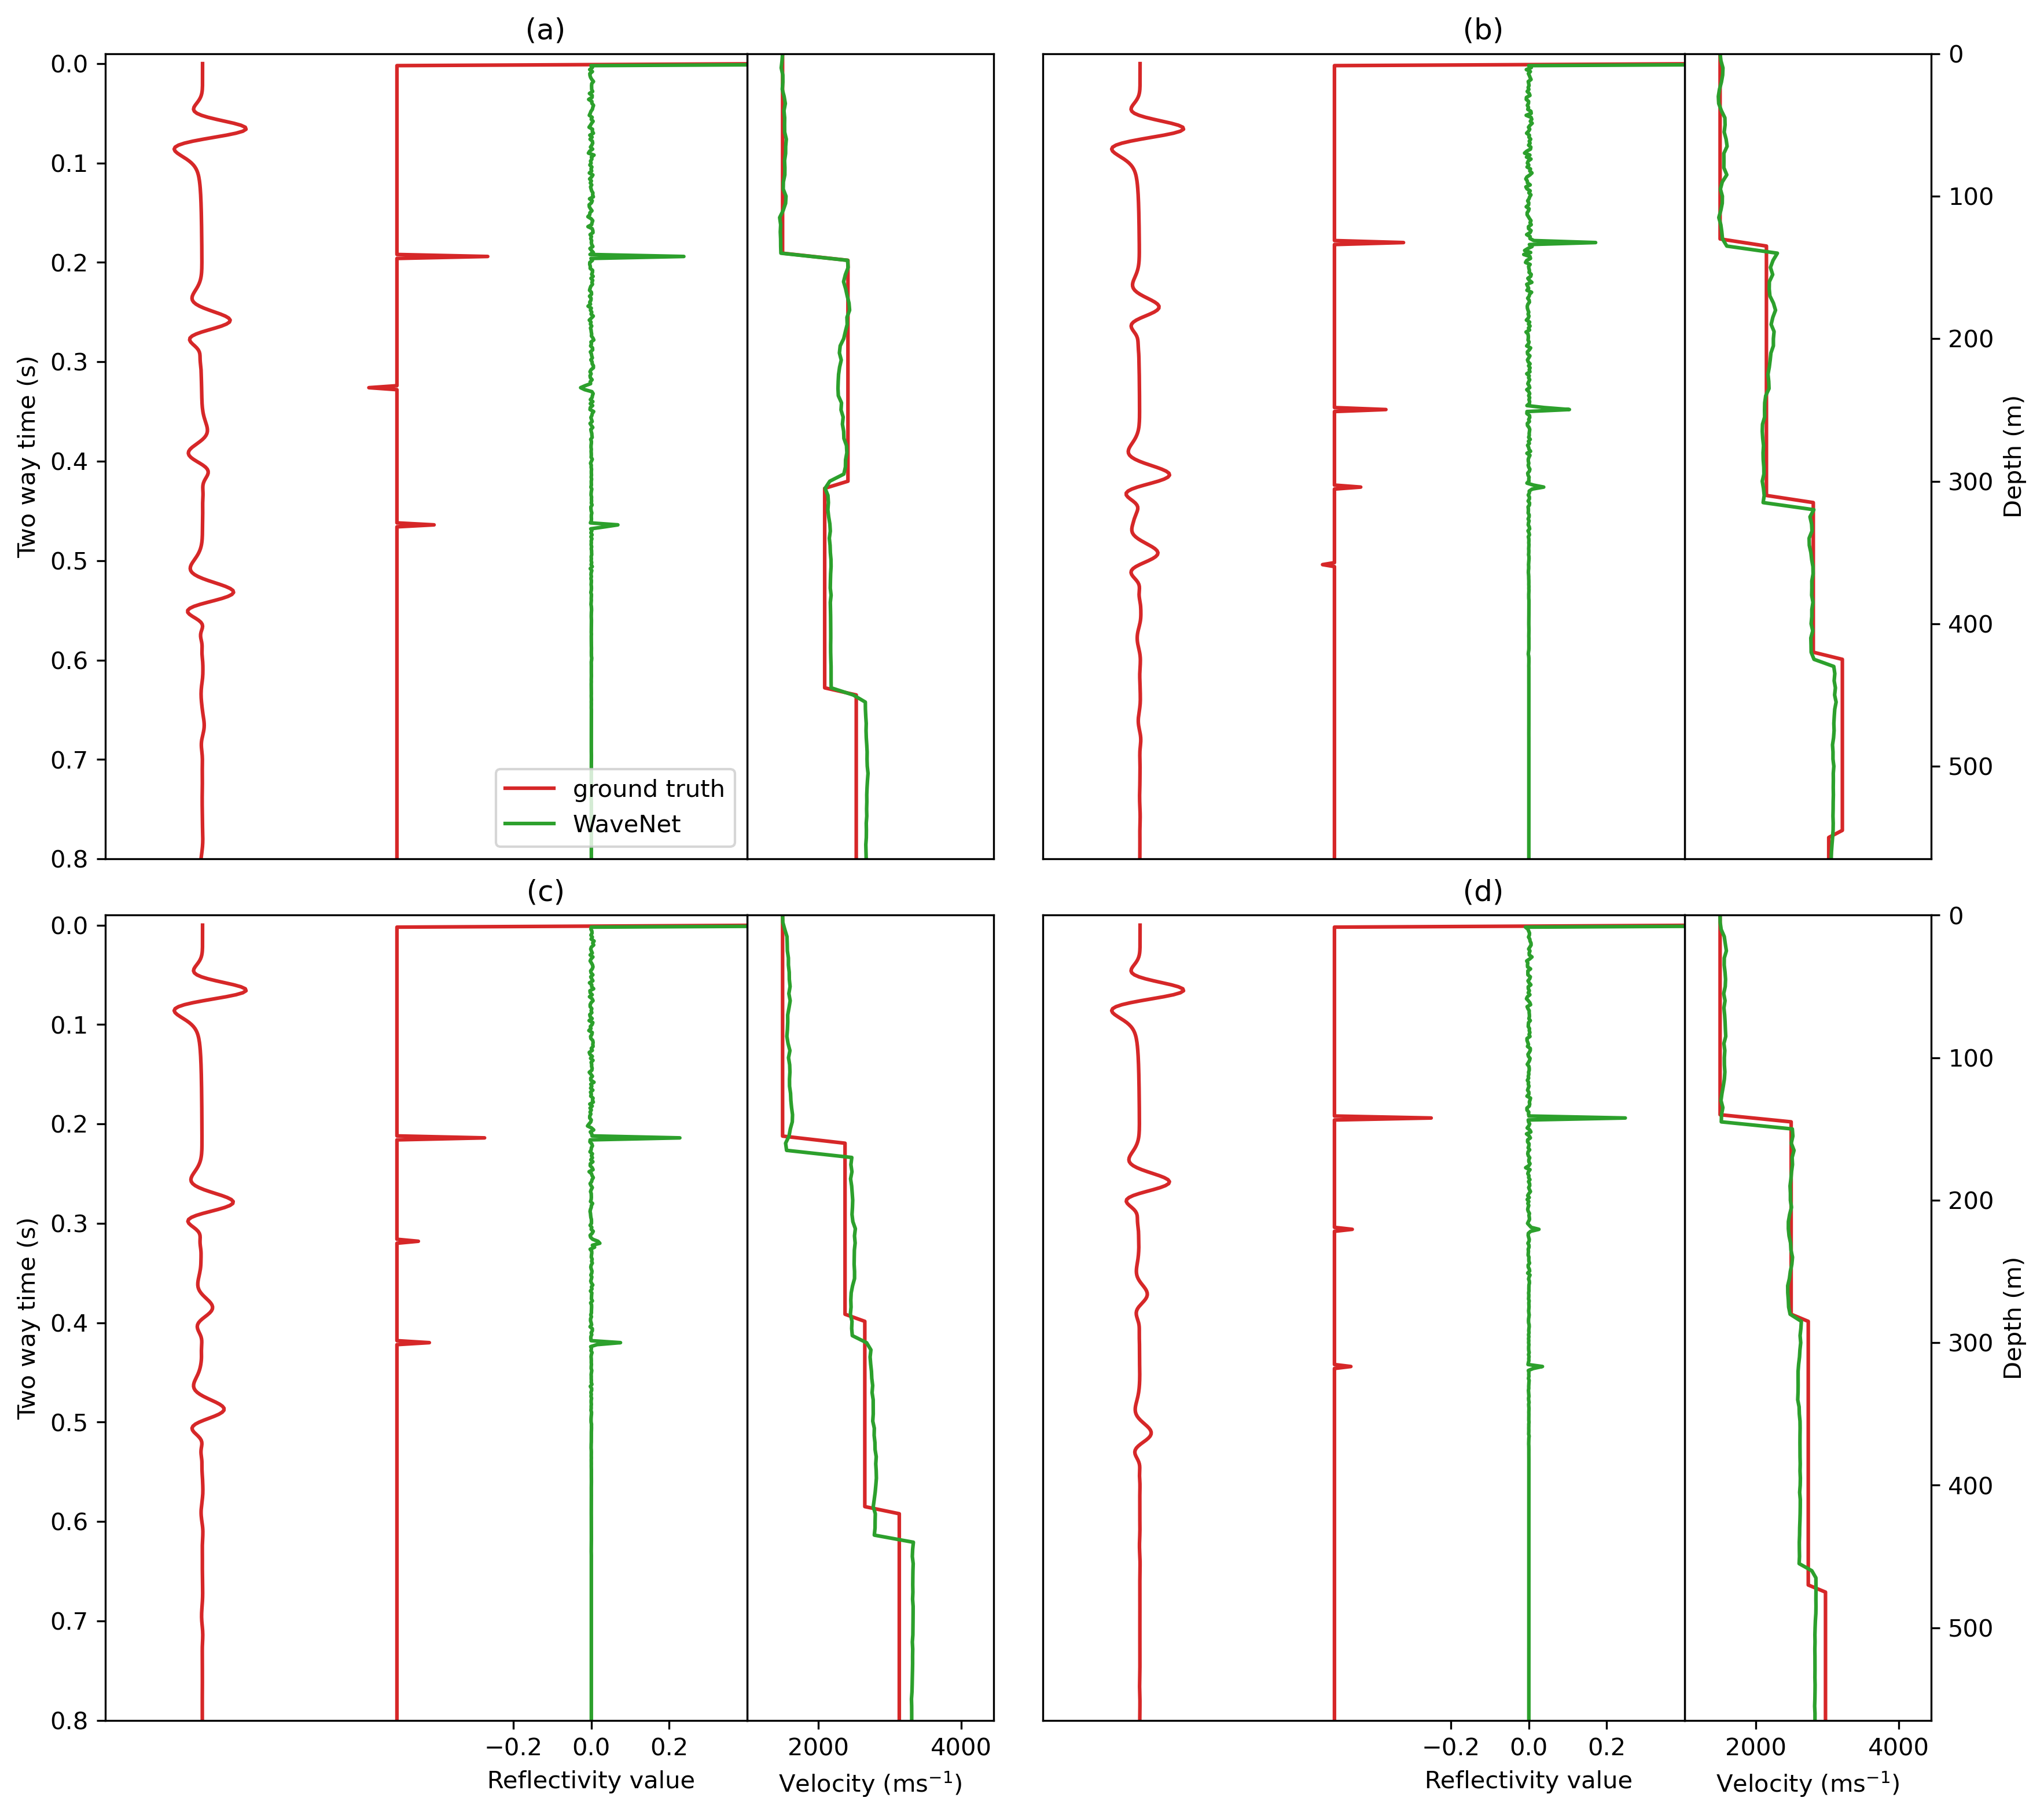

In [74]:
plt.figure(figsize=(12,12), dpi=300)

row_n = 0
for i,ib in enumerate([0,1,2,3]):
    if i == 2:
        row_n = 1
        i = 0
    if i == 3:
        i = 1
    
    v_d = processing_utils.get_velocity_trace(reflectivity_prediction_array[ib,:,0], 
                                              qc=False, srate=DT, DZ=DZ, NZ=NZ, v0=1500.)
    
    # velocity
    plt.subplot2grid((2, 38), (row_n, 13+13*i+5*i+i), colspan=5)
    
    plt.plot(velocity_array[ib,:,0], DZ*np.arange(NZ), color='tab:red',label="ground truth")
    plt.plot(v_d, DZ*np.arange(NZ), color='tab:green',label="WaveNet")
    
    plt.gca().invert_yaxis()
    if row_n == 1: plt.xlabel("Velocity ($\mathrm{ms}^{-1}$)")
    else: plt.xticks([])
    plt.xlim(1000,4450)
    plt.ylim(DZ*(NZ-1),0)
    if i==1: 
        plt.ylabel("Depth (m)")
        plt.gca().yaxis.tick_right()
        plt.gca().yaxis.set_label_position("right")
    else: plt.yticks([])
    
    # gather & reflectivity
    plt.subplot2grid((2, 38), (row_n, 0+13*i+5*i+i), colspan=13)
    if ib == 0:
        label1="ground truth"
        label2="WaveNet"
    else: label1 = label2 = None
    
    lim = 0.2
    plt.plot(-1+lim*gain*gather_array[ib,:,5], DT*np.arange(NSTEPS), color='tab:red',label=label1)
    plt.plot(-0.5+reflectivity_array[ib,:,0], DT*np.arange(NSTEPS), color='tab:red')
    plt.plot(0+reflectivity_prediction_array[ib,:,0], DT*np.arange(NSTEPS), color='tab:green',label=label2)
    if ib == 0: plt.legend(loc=4)
    
    plt.title("                          (%s)"%(letters[ib]))
    
    plt.gca().invert_yaxis()
    if row_n == 1: 
        plt.xlabel("                                           Reflectivity value")
        plt.xticks([-0.2, 0, 0.2])
    else: plt.xticks([])
    if i==0: plt.ylabel("Two way time (s)")
    else: plt.yticks([])
    plt.ylim(DT*400,-0.01)
    plt.xlim(-1-0.25, 0.4)

plt.subplots_adjust(left=0.1, right=1., bottom=0.1, top=.9, hspace=0.07, wspace=0.00)
figout_dir = './Fig/inverse/'
if not os.path.exists(figout_dir):
    os.makedirs(figout_dir)
plt.savefig(figout_dir+'WaveNet_inverse_L2_prediction.png',bbox_inches = 'tight',dpi=300,facecolor='w')#保存图片

## 使用L2+L1训练

### loss曲线图

In [75]:
PATH= '../WaveNet_train/results/summaries/'
modle = 'layers_2000_inverse_l2l1/'
l1loss_test = 'run-.-tag-accuracy_loss_test_loss.csv'
l1loss_train = 'run-.-tag-accuracy_loss_train_loss.csv'
data = pd.read_csv(PATH + modle + l1loss_test)
test_Step = data['Step'].tolist()
l1loss_test = data['Value'].tolist()
data = pd.read_csv(PATH + modle + l1loss_train)
train_Step = data['Step'].tolist()
l1loss_train = data['Value'].tolist()

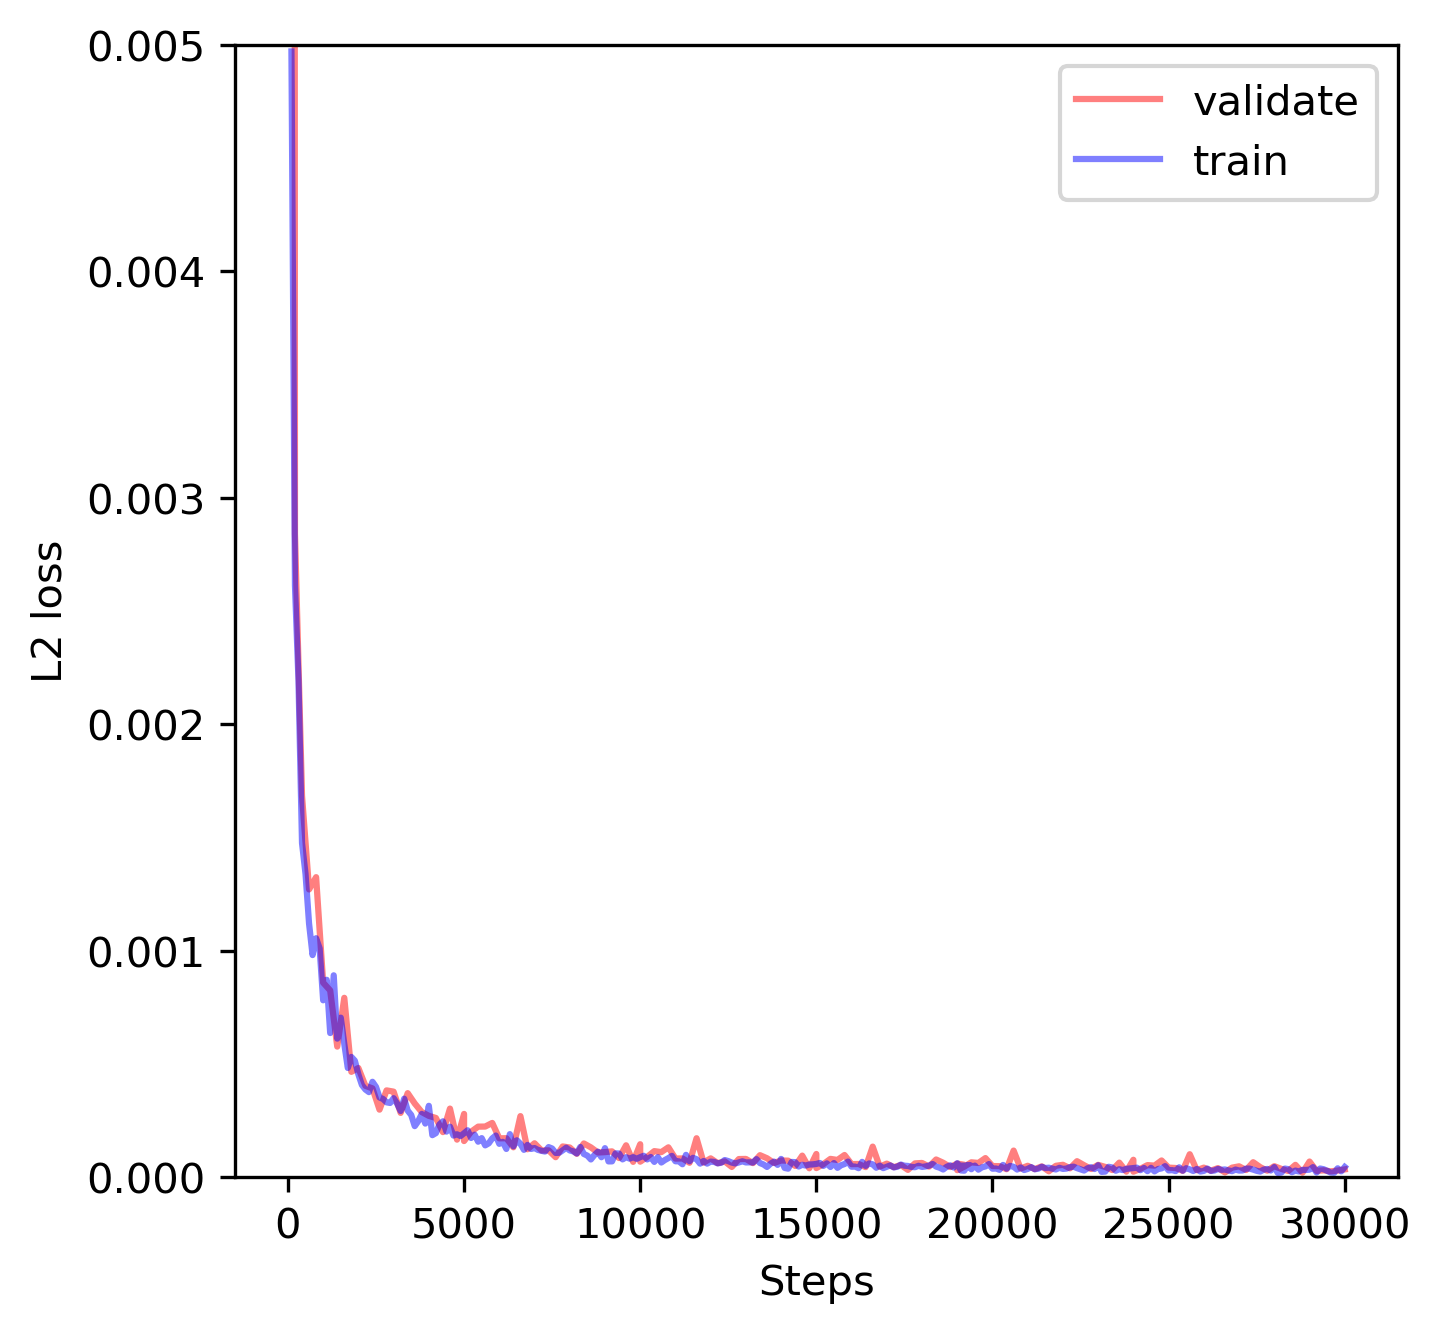

In [76]:
%matplotlib inline
fig = plt.figure(num=1, figsize=(5, 5),dpi=300)     #开启一个窗口，同时设置大小，分辨率

plt.plot(test_Step,l1loss_test,linestyle='-',alpha=0.5,color='r',label='validate')
plt.plot(train_Step,l1loss_train,linestyle='-',alpha=0.5,color='b',label='train')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('L2 loss')
plt.ylim([0,0.005])
# plt.title('18000 examples')

figout_dir = './Fig/inverse/'
if not os.path.exists(figout_dir):
    os.makedirs(figout_dir)
plt.savefig(figout_dir+'WaveNet_inverse_L2L1_loss.png',bbox_inches = 'tight',dpi=300,facecolor='w')#保存图片

### 预测结果图

In [77]:
# Load model and dataset
tf.reset_default_graph()
path = '../WaveNet_train/'
model, c_dict, input_features, sess = load_model("layers_2000_inverse_l2l1/model.ckpt-30000", rootdir=path+"results/",verbose=False)
rootdir = '../generate_data/data'
d = load_testdataset("layers_100_validate.bin", N_EXAMPLES=100, c_dict=c_dict, rootdir=rootdir,verbose=False)
# Get batches of test data
index=12
# velocity_array, reflectivity_array, gather_array = d[42,17,24,31]
velocity_array, reflectivity_array, gather_array = d[42,17,24,31]
print(velocity_array.shape, reflectivity_array.shape, gather_array.shape)

# Inference
reflectivity_prediction_array = sess.run(model.y, feed_dict={input_features["gather"]: gather_array})

Loading model from: ../WaveNet_train/results/models/layers_2000_inverse_l2l1/model.ckpt-30000
INFO:tensorflow:Restoring parameters from ../WaveNet_train/results/models/layers_2000_inverse_l2l1/model.ckpt-30000
(4, 114, 1) (4, 512, 1) (4, 512, 11)


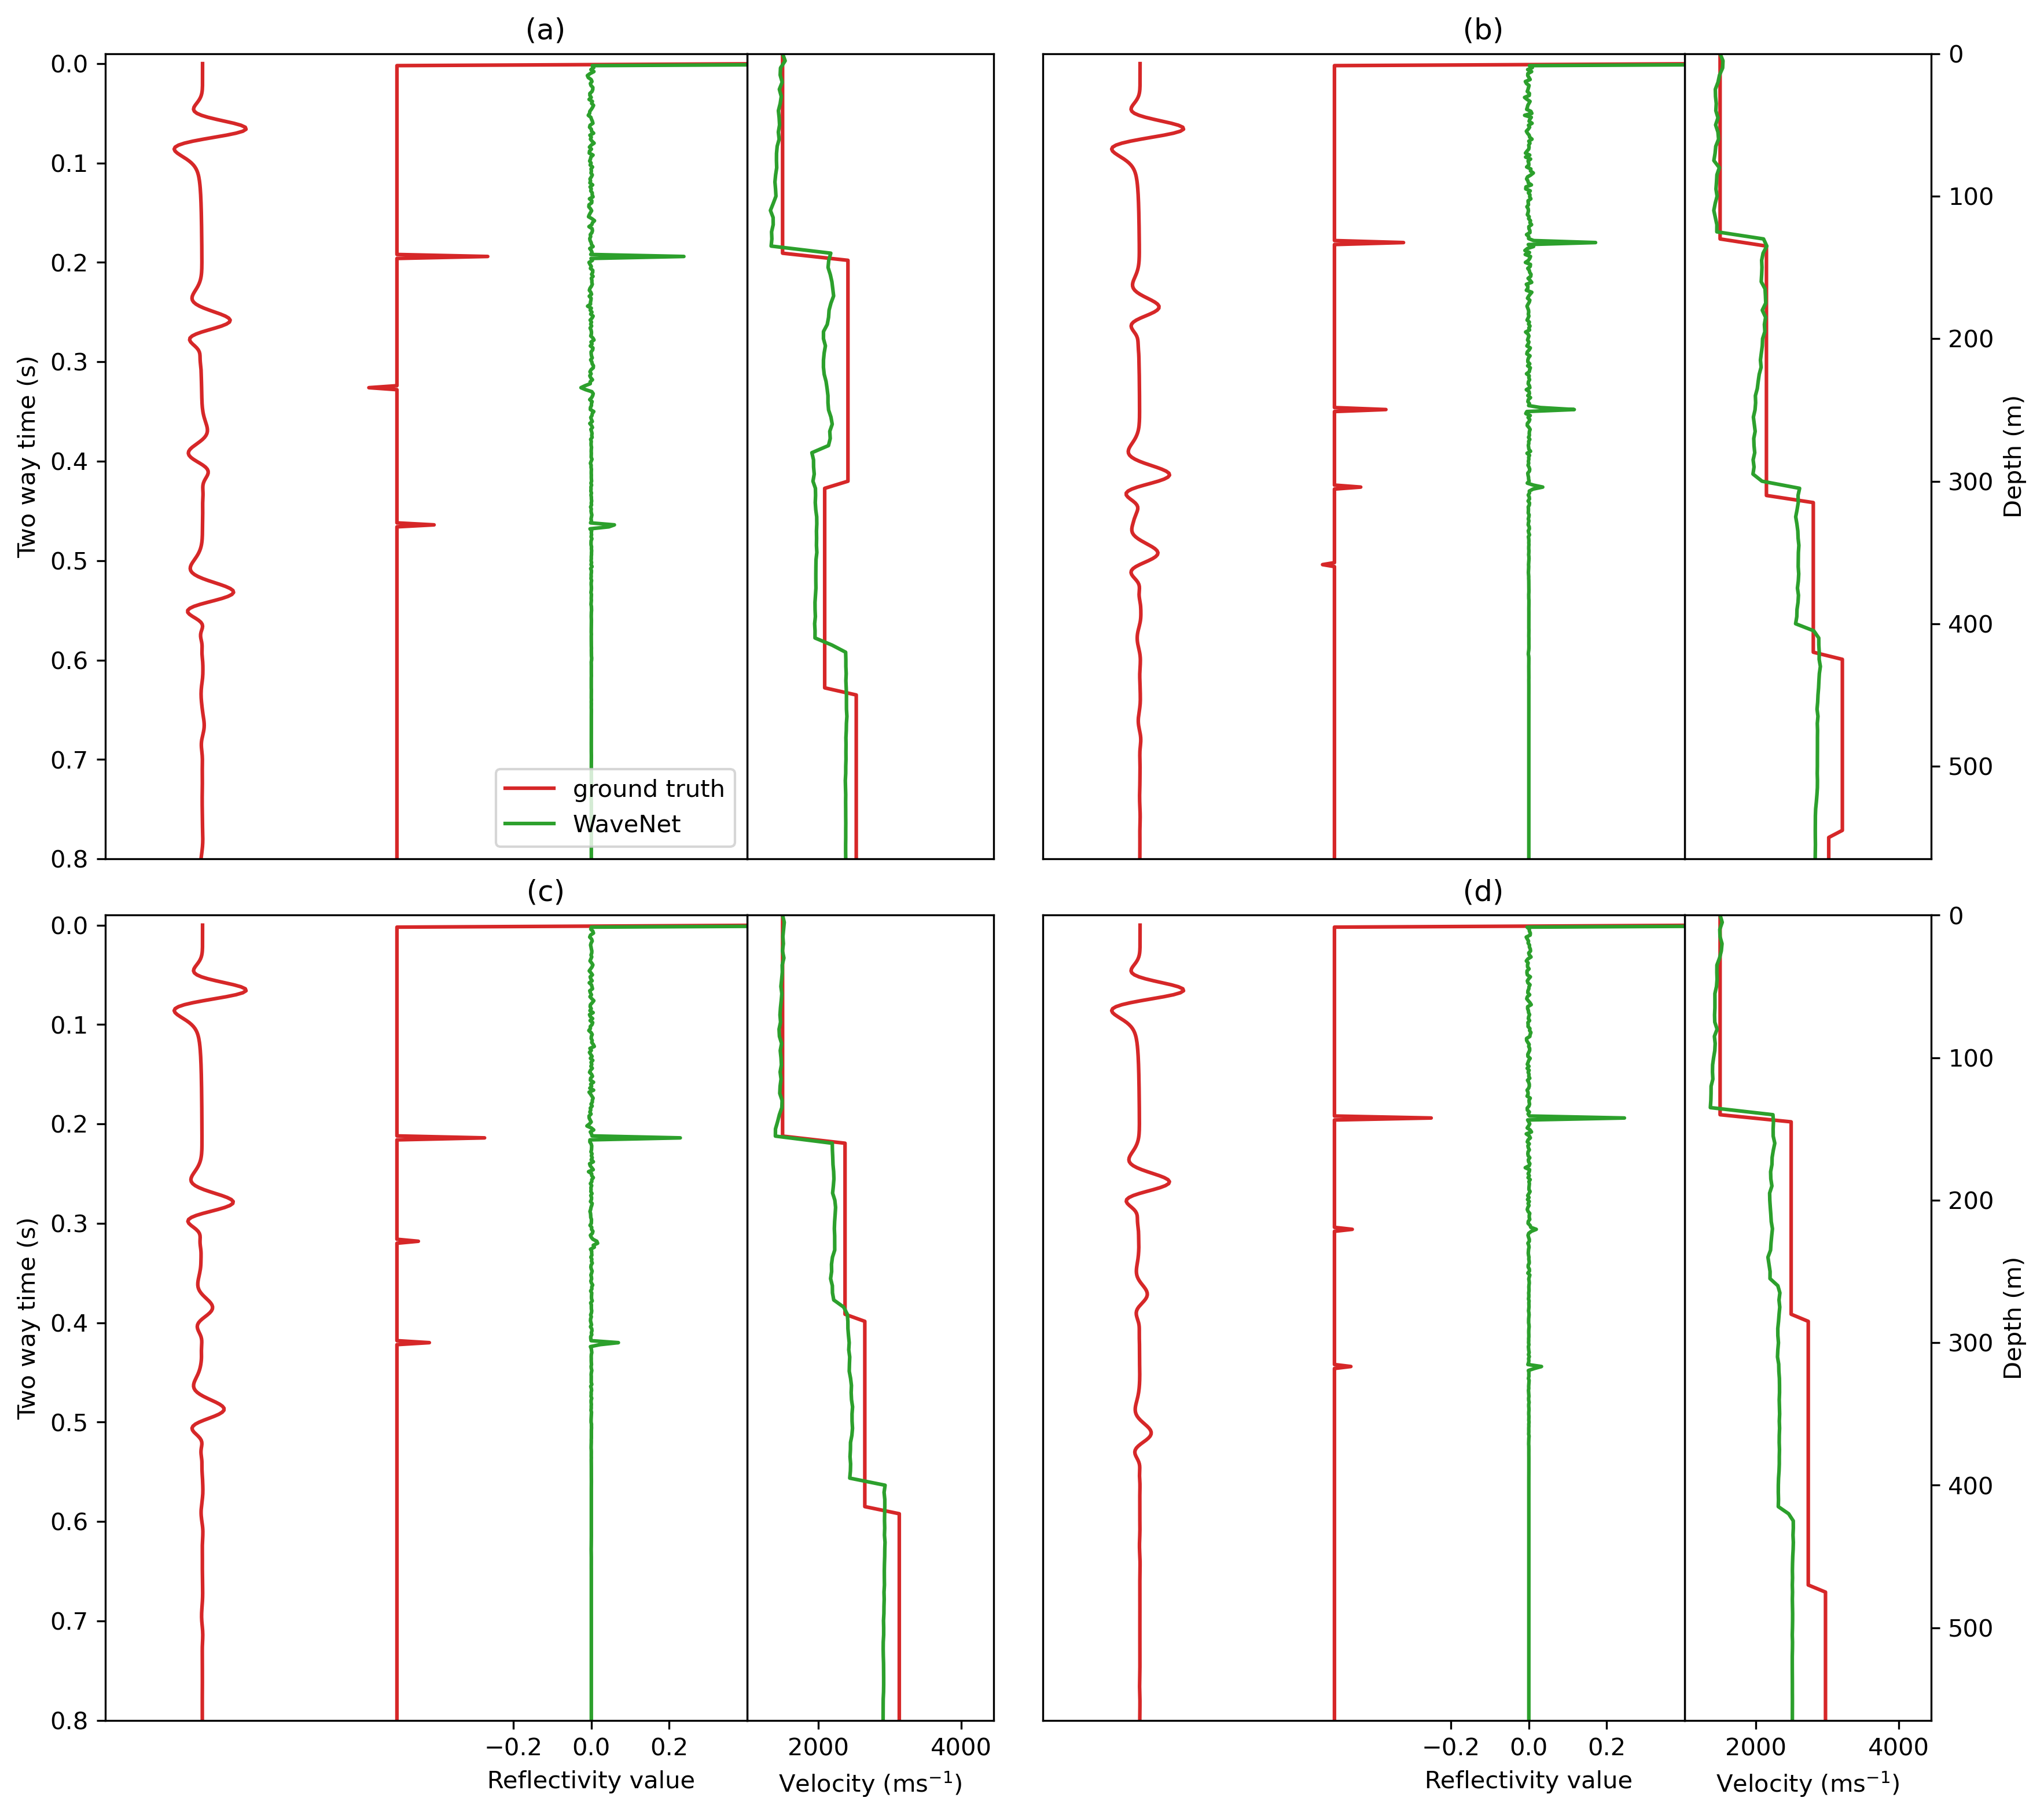

In [78]:
plt.figure(figsize=(12,12), dpi=300)

row_n = 0
for i,ib in enumerate([0,1,2,3]):
    if i == 2:
        row_n = 1
        i = 0
    if i == 3:
        i = 1
    
    v_d = processing_utils.get_velocity_trace(reflectivity_prediction_array[ib,:,0], 
                                              qc=False, srate=DT, DZ=DZ, NZ=NZ, v0=1500.)
    
    # velocity
    plt.subplot2grid((2, 38), (row_n, 13+13*i+5*i+i), colspan=5)
    
    plt.plot(velocity_array[ib,:,0], DZ*np.arange(NZ), color='tab:red',label="ground truth")
    plt.plot(v_d, DZ*np.arange(NZ), color='tab:green',label="WaveNet")
    
    plt.gca().invert_yaxis()
    if row_n == 1: plt.xlabel("Velocity ($\mathrm{ms}^{-1}$)")
    else: plt.xticks([])
    plt.xlim(1000,4450)
    plt.ylim(DZ*(NZ-1),0)
    if i==1: 
        plt.ylabel("Depth (m)")
        plt.gca().yaxis.tick_right()
        plt.gca().yaxis.set_label_position("right")
    else: plt.yticks([])
    
    # gather & reflectivity
    plt.subplot2grid((2, 38), (row_n, 0+13*i+5*i+i), colspan=13)
    if ib == 0:
        label1="ground truth"
        label2="WaveNet"
    else: label1 = label2 = None
    
    lim = 0.2
    plt.plot(-1+lim*gain*gather_array[ib,:,5], DT*np.arange(NSTEPS), color='tab:red',label=label1)
    plt.plot(-0.5+reflectivity_array[ib,:,0], DT*np.arange(NSTEPS), color='tab:red')
    plt.plot(0+reflectivity_prediction_array[ib,:,0], DT*np.arange(NSTEPS), color='tab:green',label=label2)
    if ib == 0: plt.legend(loc=4)
    
    plt.title("                          (%s)"%(letters[ib]))
    
    plt.gca().invert_yaxis()
    if row_n == 1: 
        plt.xlabel("                                           Reflectivity value")
        plt.xticks([-0.2, 0, 0.2])
    else: plt.xticks([])
    if i==0: plt.ylabel("Two way time (s)")
    else: plt.yticks([])
    plt.ylim(DT*400,-0.01)
    plt.xlim(-1-0.25, 0.4)

plt.subplots_adjust(left=0.1, right=1., bottom=0.1, top=.9, hspace=0.07, wspace=0.00)
figout_dir = './Fig/inverse/'
if not os.path.exists(figout_dir):
    os.makedirs(figout_dir)
plt.savefig(figout_dir+'WaveNet_inverse_L2L1_prediction.png',bbox_inches = 'tight',dpi=300,facecolor='w')#保存图片

# 网络的抗噪性测试

## 使用L2训练的模型预测带噪数据

In [79]:
# Load model and dataset
tf.reset_default_graph()
path = '../WaveNet_train/'
model, c_dict, input_features, sess = load_model("layers_2000_inverse_l2/model.ckpt-30000", rootdir=path+"results/",verbose=False)
rootdir = '../generate_data/data'
d = load_testdataset("layers_100_validate_25noise.bin", N_EXAMPLES=100, c_dict=c_dict, rootdir=rootdir,verbose=False)
# Get batches of test data
index=12
# velocity_array, reflectivity_array, gather_array = d[42,17,24,31]
velocity_array, reflectivity_array, gather_array = d[42,17,24,31]
print(velocity_array.shape, reflectivity_array.shape, gather_array.shape)

# Inference
reflectivity_prediction_array = sess.run(model.y, feed_dict={input_features["gather"]: gather_array})

Loading model from: ../WaveNet_train/results/models/layers_2000_inverse_l2/model.ckpt-30000
INFO:tensorflow:Restoring parameters from ../WaveNet_train/results/models/layers_2000_inverse_l2/model.ckpt-30000
(4, 114, 1) (4, 512, 1) (4, 512, 11)


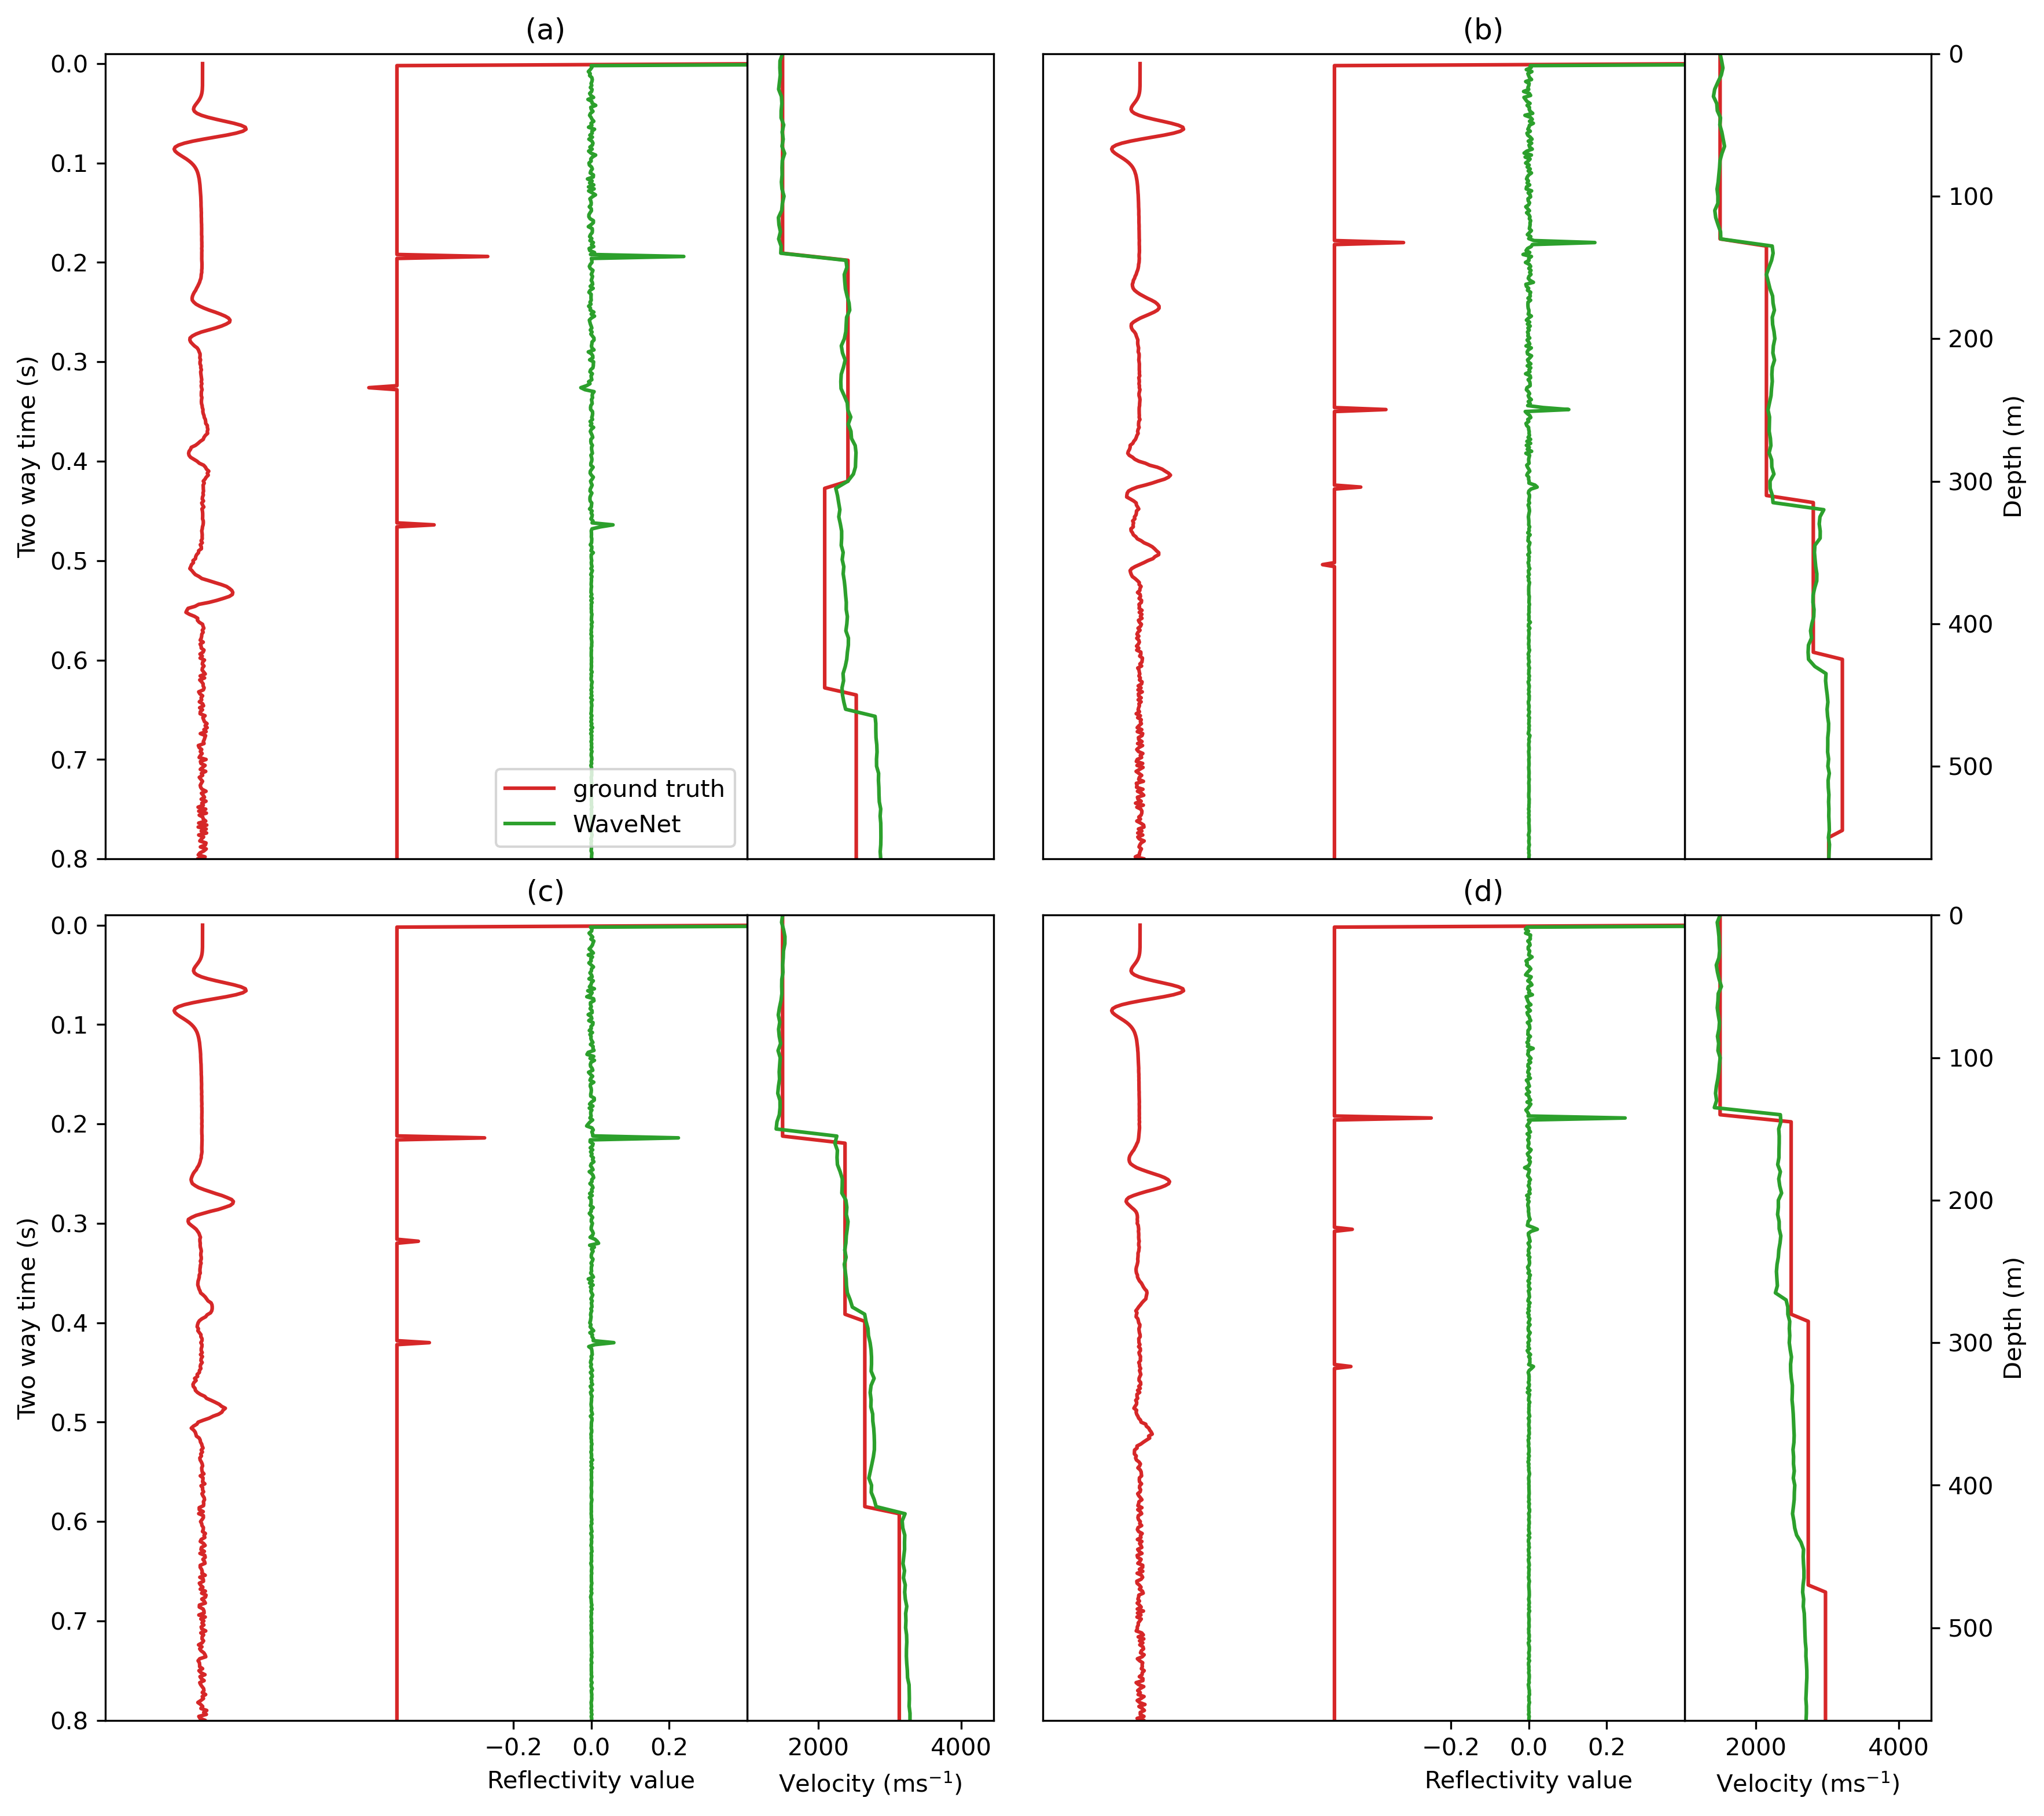

In [80]:
plt.figure(figsize=(12,12), dpi=300)

row_n = 0
for i,ib in enumerate([0,1,2,3]):
    if i == 2:
        row_n = 1
        i = 0
    if i == 3:
        i = 1
    
    v_d = processing_utils.get_velocity_trace(reflectivity_prediction_array[ib,:,0], 
                                              qc=False, srate=DT, DZ=DZ, NZ=NZ, v0=1500.)
    
    # velocity
    plt.subplot2grid((2, 38), (row_n, 13+13*i+5*i+i), colspan=5)
    
    plt.plot(velocity_array[ib,:,0], DZ*np.arange(NZ), color='tab:red',label="ground truth")
    plt.plot(v_d, DZ*np.arange(NZ), color='tab:green',label="WaveNet")
    
    plt.gca().invert_yaxis()
    if row_n == 1: plt.xlabel("Velocity ($\mathrm{ms}^{-1}$)")
    else: plt.xticks([])
    plt.xlim(1000,4450)
    plt.ylim(DZ*(NZ-1),0)
    if i==1: 
        plt.ylabel("Depth (m)")
        plt.gca().yaxis.tick_right()
        plt.gca().yaxis.set_label_position("right")
    else: plt.yticks([])
    
    # gather & reflectivity
    plt.subplot2grid((2, 38), (row_n, 0+13*i+5*i+i), colspan=13)
    if ib == 0:
        label1="ground truth"
        label2="WaveNet"
    else: label1 = label2 = None
    
    lim = 0.2
    plt.plot(-1+lim*gain*gather_array[ib,:,5], DT*np.arange(NSTEPS), color='tab:red',label=label1)
    plt.plot(-0.5+reflectivity_array[ib,:,0], DT*np.arange(NSTEPS), color='tab:red')
    plt.plot(0+reflectivity_prediction_array[ib,:,0], DT*np.arange(NSTEPS), color='tab:green',label=label2)
    if ib == 0: plt.legend(loc=4)
    
    plt.title("                          (%s)"%(letters[ib]))
    
    plt.gca().invert_yaxis()
    if row_n == 1: 
        plt.xlabel("                                           Reflectivity value")
        plt.xticks([-0.2, 0, 0.2])
    else: plt.xticks([])
    if i==0: plt.ylabel("Two way time (s)")
    else: plt.yticks([])
    plt.ylim(DT*400,-0.01)
    plt.xlim(-1-0.25, 0.4)

plt.subplots_adjust(left=0.1, right=1., bottom=0.1, top=.9, hspace=0.07, wspace=0.00)
figout_dir = './Fig/noise/'
if not os.path.exists(figout_dir):
    os.makedirs(figout_dir)
plt.savefig(figout_dir+'WaveNet_inverse_L2_prediction_noise.png',bbox_inches = 'tight',dpi=300,facecolor='w')#保存图片

## 使用L2+L1训练的模型预测带噪数据

In [81]:
# Load model and dataset
tf.reset_default_graph()
path = '../WaveNet_train/'
model, c_dict, input_features, sess = load_model("layers_2000_inverse_l2l1/model.ckpt-30000", rootdir=path+"results/",verbose=False)
rootdir = '../generate_data/data'
d = load_testdataset("layers_100_validate_25noise.bin", N_EXAMPLES=100, c_dict=c_dict, rootdir=rootdir,verbose=False)
# Get batches of test data
index=12
# velocity_array, reflectivity_array, gather_array = d[42,17,24,31]
velocity_array, reflectivity_array, gather_array = d[42,17,24,31]
print(velocity_array.shape, reflectivity_array.shape, gather_array.shape)

# Inference
reflectivity_prediction_array = sess.run(model.y, feed_dict={input_features["gather"]: gather_array})

Loading model from: ../WaveNet_train/results/models/layers_2000_inverse_l2l1/model.ckpt-30000
INFO:tensorflow:Restoring parameters from ../WaveNet_train/results/models/layers_2000_inverse_l2l1/model.ckpt-30000
(4, 114, 1) (4, 512, 1) (4, 512, 11)


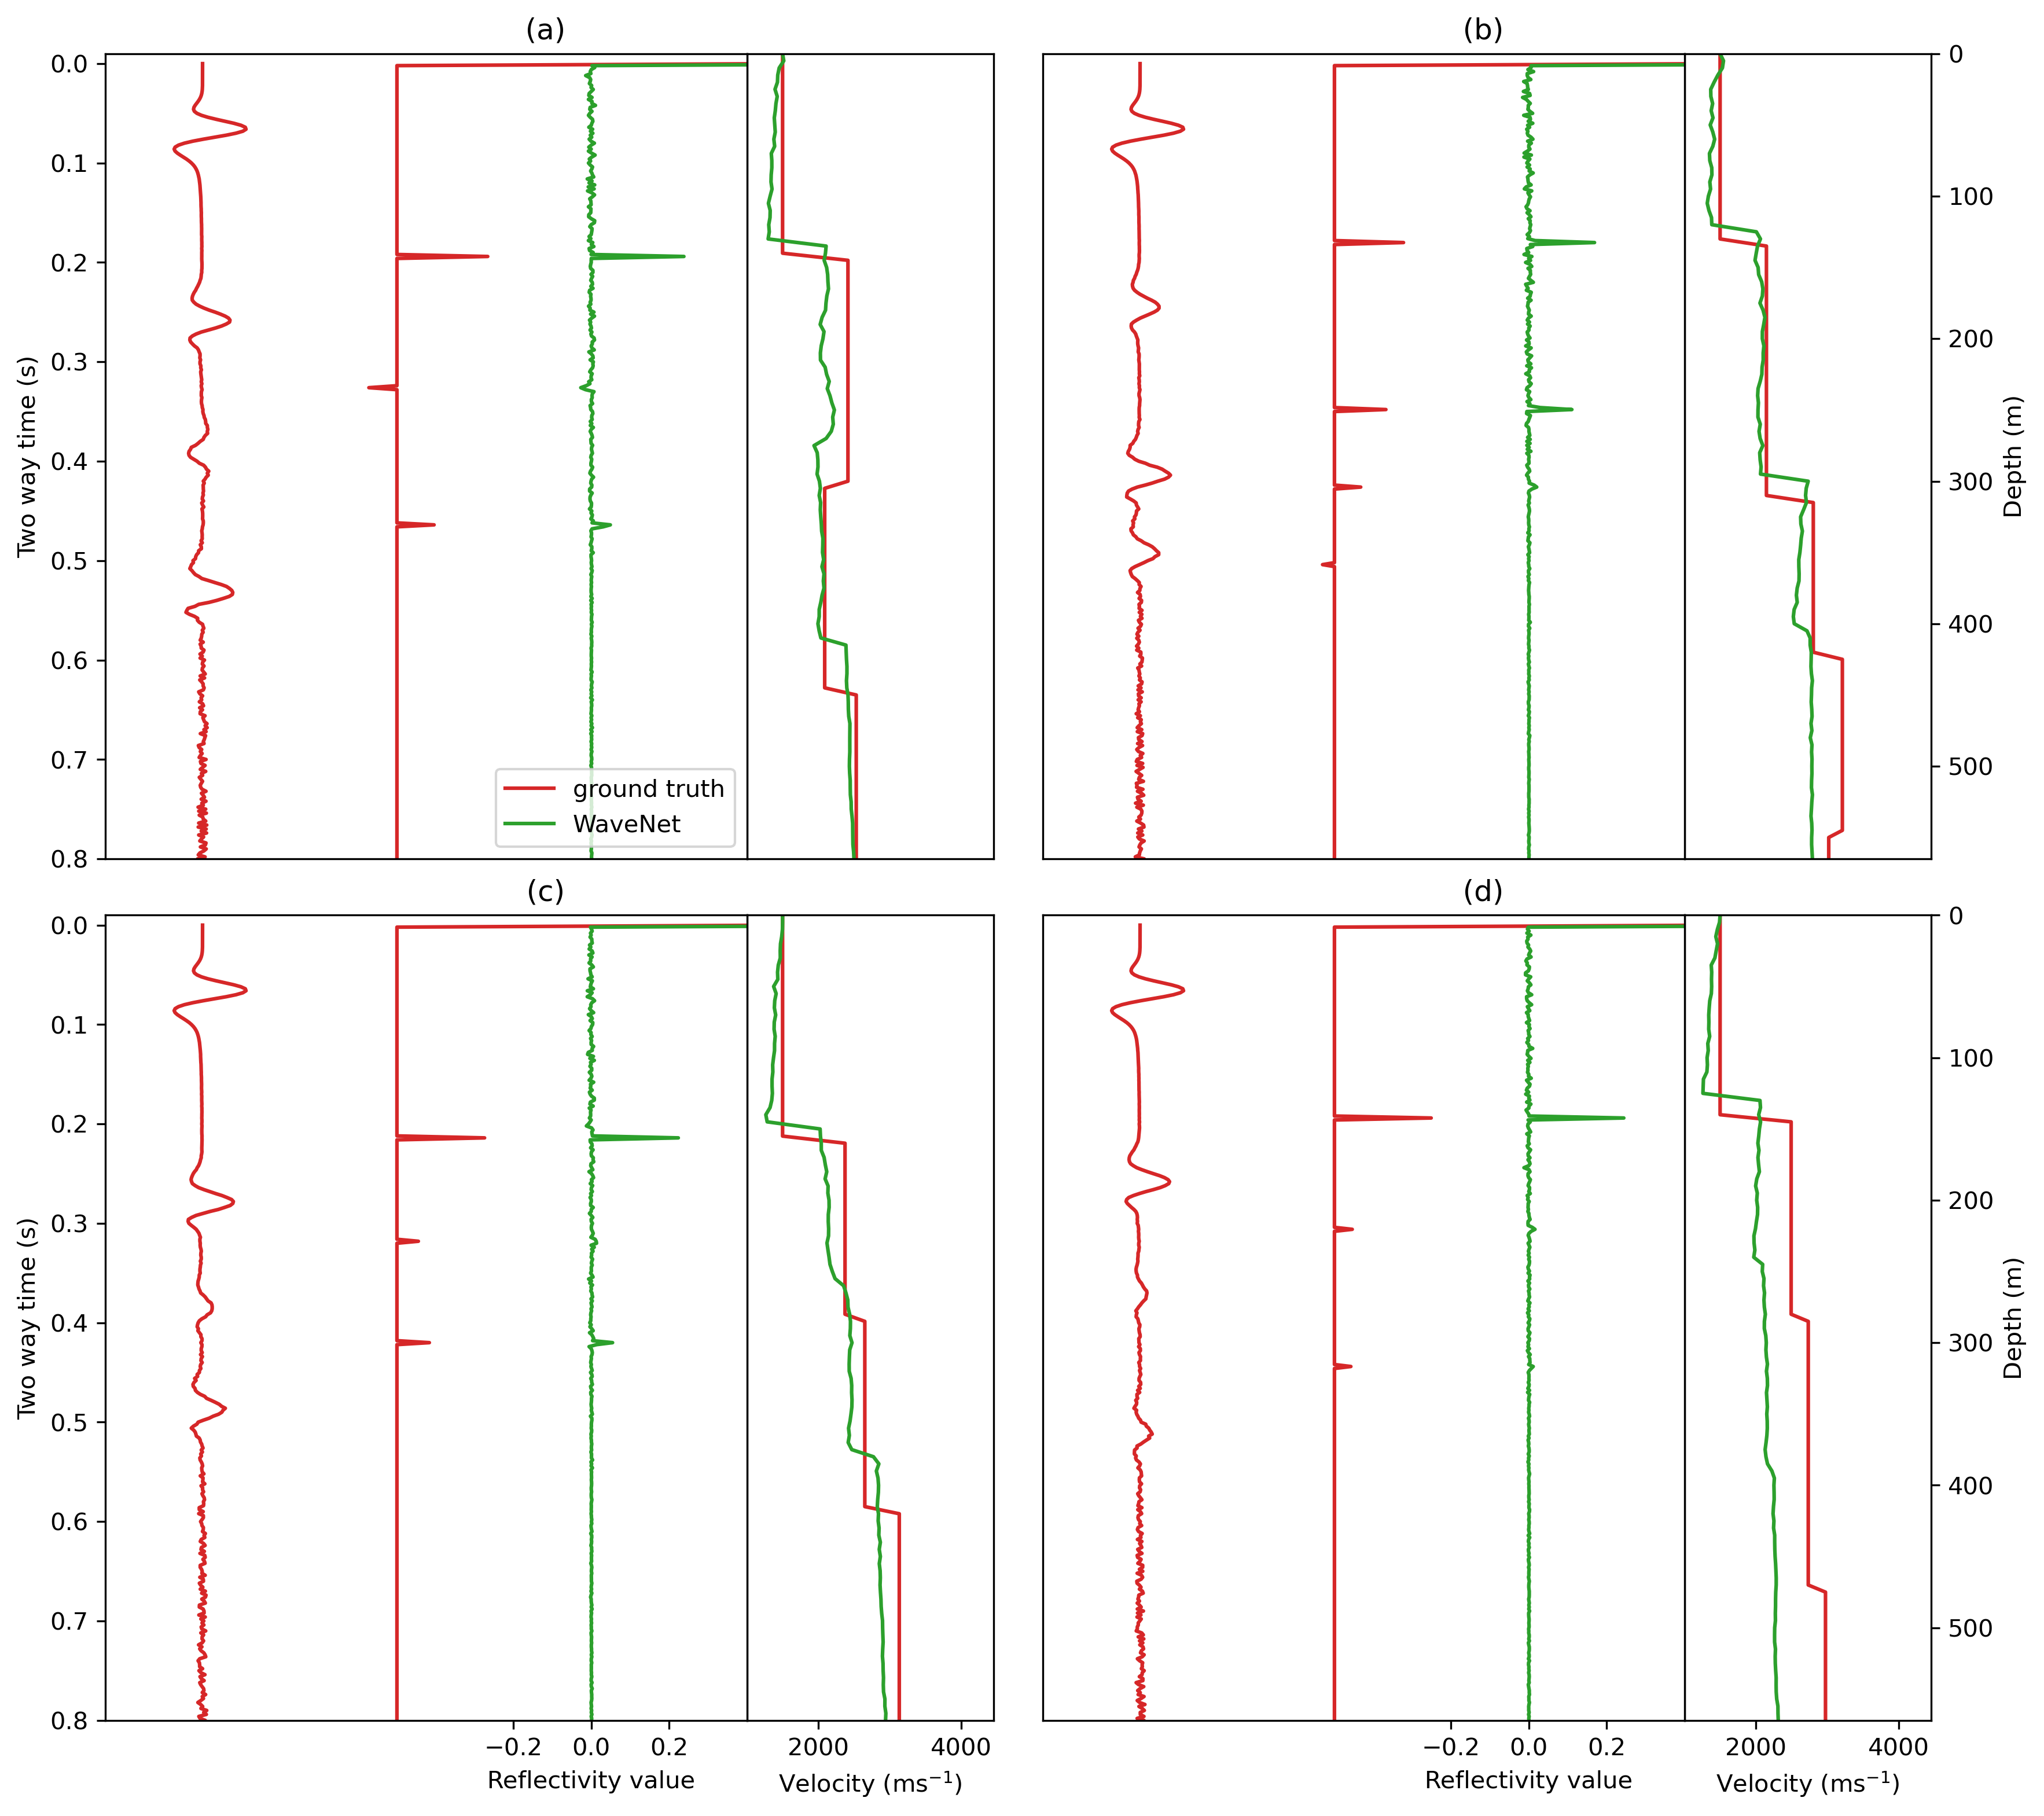

In [82]:
plt.figure(figsize=(12,12), dpi=300)

row_n = 0
for i,ib in enumerate([0,1,2,3]):
    if i == 2:
        row_n = 1
        i = 0
    if i == 3:
        i = 1
    
    v_d = processing_utils.get_velocity_trace(reflectivity_prediction_array[ib,:,0], 
                                              qc=False, srate=DT, DZ=DZ, NZ=NZ, v0=1500.)
    
    # velocity
    plt.subplot2grid((2, 38), (row_n, 13+13*i+5*i+i), colspan=5)
    
    plt.plot(velocity_array[ib,:,0], DZ*np.arange(NZ), color='tab:red',label="ground truth")
    plt.plot(v_d, DZ*np.arange(NZ), color='tab:green',label="WaveNet")
    
    plt.gca().invert_yaxis()
    if row_n == 1: plt.xlabel("Velocity ($\mathrm{ms}^{-1}$)")
    else: plt.xticks([])
    plt.xlim(1000,4450)
    plt.ylim(DZ*(NZ-1),0)
    if i==1: 
        plt.ylabel("Depth (m)")
        plt.gca().yaxis.tick_right()
        plt.gca().yaxis.set_label_position("right")
    else: plt.yticks([])
    
    # gather & reflectivity
    plt.subplot2grid((2, 38), (row_n, 0+13*i+5*i+i), colspan=13)
    if ib == 0:
        label1="ground truth"
        label2="WaveNet"
    else: label1 = label2 = None
    
    lim = 0.2
    plt.plot(-1+lim*gain*gather_array[ib,:,5], DT*np.arange(NSTEPS), color='tab:red',label=label1)
    plt.plot(-0.5+reflectivity_array[ib,:,0], DT*np.arange(NSTEPS), color='tab:red')
    plt.plot(0+reflectivity_prediction_array[ib,:,0], DT*np.arange(NSTEPS), color='tab:green',label=label2)
    if ib == 0: plt.legend(loc=4)
    
    plt.title("                          (%s)"%(letters[ib]))
    
    plt.gca().invert_yaxis()
    if row_n == 1: 
        plt.xlabel("                                           Reflectivity value")
        plt.xticks([-0.2, 0, 0.2])
    else: plt.xticks([])
    if i==0: plt.ylabel("Two way time (s)")
    else: plt.yticks([])
    plt.ylim(DT*400,-0.01)
    plt.xlim(-1-0.25, 0.4)

plt.subplots_adjust(left=0.1, right=1., bottom=0.1, top=.9, hspace=0.07, wspace=0.00)
figout_dir = './Fig/noise/'
if not os.path.exists(figout_dir):
    os.makedirs(figout_dir)
plt.savefig(figout_dir+'WaveNet_inverse_L2L1_prediction_noise.png',bbox_inches = 'tight',dpi=300,facecolor='w')#保存图片